In [1]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn import svm, linear_model, naive_bayes, neural_network, neighbors, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
import random, math
import numpy as np
import scipy.sparse as sp
from datetime import datetime
from collections import Counter
from itertools import combinations

import itertools

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import warnings
warnings.simplefilter("ignore")
from tqdm import tqdm_notebook as tqdm

In [2]:
cd classification_txt_files

/Volumes/S190813/Music_Box/LTSM_Generative_Music/Classification_Evaluation/classification_txt_files


In [3]:
p = !pwd
p = p.pop()
e = '/'
p = p + e
p

'/Volumes/S190813/Music_Box/LTSM_Generative_Music/Classification_Evaluation/classification_txt_files/'

## BACH

In [4]:
with open(p + 'bach_xml_list.txt', 'r') as f:
    ba_dataset = [piece.strip() for piece in f.readlines()]
    bach_data = [f for f in ba_dataset if f.replace('-', '_').split('_')[0] == 'bach']
with open('bach-chordsequence.txt', 'r') as f:
    BACH = [' '.join(piece.strip('[]\n').split(', ')) for piece in f.readlines()]
    BACH = [(BACH[i], bach_data[i]) for i in range(len(BACH))]

## BEETHOVEN

In [5]:
with open(p + 'beethoven_xml_list.txt', 'r') as f:
    be_dataset = [piece.strip() for piece in f.readlines()]
    beethoven_data = [f for f in be_dataset if f.replace('-', '_').split('_')[0] == 'beethoven']
with open('beethoven-chordsequence.txt', 'r') as f:
    BEETHOVEN = [' '.join(piece.strip('[]\n').split(', ')) for piece in f.readlines()]
    BEETHOVEN = [(BEETHOVEN[i], beethoven_data[i]) for i in range(len(BEETHOVEN))]

## CHOPIN

In [6]:
with open(p + 'chopin_xml_list.txt', 'r') as f:
    ch_dataset = [piece.strip() for piece in f.readlines()]
    chopin_data = [f for f in ch_dataset if f.replace('-', '_').split('_')[0] == 'chopin']
with open('chopin-chordsequence.txt', 'r') as f:
    CHOPIN = [' '.join(piece.strip('[]\n').split(', ')) for piece in f.readlines()]
    CHOPIN = [(CHOPIN[i], chopin_data[i]) for i in range(len(CHOPIN))]

## DEBUSSY

In [7]:
with open(p + 'debussy_xml_list.txt', 'r') as f:
    de_dataset = [piece.strip() for piece in f.readlines()]
    debussy_data = [f for f in de_dataset if f.replace('-', '_').split('_')[0] == 'debussy']
with open('debussy-chordsequence.txt', 'r') as f:
    DEBUSSY = [' '.join(piece.strip('[]\n').split(', ')) for piece in f.readlines()]
    DEBUSSY = [(DEBUSSY[i], debussy_data[i]) for i in range(len(DEBUSSY))]

## RAVEL

In [8]:
with open(p + 'ravel_xml_list.txt', 'r') as f:
    ra_dataset = [piece.strip() for piece in f.readlines()]
    ravel_data = [f for f in ra_dataset if f.replace('-', '_').split('_')[0] == 'ravel']
with open('ravel-chordsequence.txt', 'r') as f:
    RAVEL = [' '.join(piece.strip('[]\n').split(', ')) for piece in f.readlines()]
    RAVEL = [(RAVEL[i], ravel_data[i]) for i in range(len(RAVEL))]

## Making NGrams out of Chord Sequences

In [9]:
def find_ngrams(input_list, N=4):
    return [' '.join(input_list[i:i+N]) for i in range(len(input_list)-N+1)]

def ngrams_by_composer(composer): 
    for i in range(1,5):
        ngrams = []
        for piece in composer:
            ngrams += find_ngrams(piece[0].split(' '), i)
        print(len(ngrams), '{}-grams total;'.format(str(i)), len(set(ngrams)), 'unique')
    print('-')

def show_ngrams(composer_data, composer_name):
    print(composer_name, ':', len(composer_data), 'pieces')
    ngrams_by_composer(composer_data)

In [10]:
show_ngrams(BACH,'bach')
show_ngrams(BEETHOVEN,'beethoven')
show_ngrams(CHOPIN,'chopin')
show_ngrams(DEBUSSY,'debussy')
show_ngrams(RAVEL, 'ravel')
show_ngrams(BACH+BEETHOVEN+CHOPIN+DEBUSSY+RAVEL, 'all composers')

bach : 287 pieces
231865 1-grams total; 181 unique
231578 2-grams total; 17887 unique
231291 3-grams total; 129721 unique
231004 4-grams total; 192144 unique
-
beethoven : 56 pieces
54927 1-grams total; 176 unique
54871 2-grams total; 10647 unique
54815 3-grams total; 33507 unique
54759 4-grams total; 42444 unique
-
chopin : 191 pieces
108128 1-grams total; 175 unique
107937 2-grams total; 15992 unique
107746 3-grams total; 67627 unique
107555 4-grams total; 88143 unique
-
debussy : 199 pieces
82362 1-grams total; 172 unique
82163 2-grams total; 10797 unique
81964 3-grams total; 38978 unique
81765 4-grams total; 55635 unique
-
ravel : 6 pieces
4217 1-grams total; 172 unique
4211 2-grams total; 2613 unique
4205 3-grams total; 3678 unique
4199 4-grams total; 3904 unique
-
all composers : 739 pieces
481499 1-grams total; 188 unique
480760 2-grams total; 23964 unique
480021 3-grams total; 229263 unique
479282 4-grams total; 367492 unique
-


In [11]:
def build_Xy(composers, size=1):
    if size >= 1: # use every rows
        indices = [range(len(composer)) for composer in composers]
    else:
        indices = [random.sample(range(len(composer)), math.ceil(size*len(composer))) for composer in composers]

    y = []
    for i in range(len(composers)):
        y += [i for n in range(len(indices[i]))]
    
    X = []
    for i in range(len(composers)):
        X += [composers[i][j] for j in indices[i]]
    
    return X, np.array(y, dtype='int16')

In [12]:
def crossvalidate(X_tuple, y, classifiers, vectorizer, NGRAMRANGE, K=10):    
    for clf in classifiers:
        clf.cm_sum = np.zeros([len(set(y)),len(set(y))], dtype='int16')
        clf.accuracies, clf.fones, clf.misclassified, clf.runningtime = [], [], [], []
        clf.fones_micro, clf.fones_macro = [], []
        clf.name = str(clf).split('(')[0]

    X = np.array([piece[0] for piece in X_tuple])
    filenames = np.array([piece[1] for piece in X_tuple])
    kf = KFold(n_splits=K, shuffle=True)
    for train_index, test_index in kf.split(y):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        
        vct = vectorizer.set_params(lowercase=False, token_pattern=u"(?u)\\b\\w+\\b", ngram_range=NGRAMRANGE)
        X_train_tfidf = vct.fit_transform(X_train)
#         X_test_tfidf = tfidf.transform(X_test)  # i think this computes tf-idf values using the whole test set, but i want each piece to be treated separately
        X_test_tfidf = sp.vstack([vct.transform(np.array([piece])) for piece in X_test])
        
        for clf in classifiers:
            t = datetime.now()
            clf.fit(X_train_tfidf, y_train)
            y_pred = clf.predict(X_test_tfidf)
            clf.runningtime.append((datetime.now()-t).total_seconds())
#             print(y_test)
#             print(y_pred)
#             print(confusion_matrix(y_test, y_pred))
            
            clf.cm_sum += confusion_matrix(y_test, y_pred)
            clf.misclassified.append(test_index[np.where(y_test != y_pred)]) # http://stackoverflow.com/a/25570632
            clf.accuracies.append(accuracy_score(y_test, y_pred))
            clf.fones.append(f1_score(y_test, y_pred, average='weighted'))
            clf.fones_micro.append(f1_score(y_test, y_pred, average='micro'))
            clf.fones_macro.append(f1_score(y_test, y_pred, average='macro'))

    result = dict()
    for clf in classifiers:
        clf.misclassified = np.sort(np.hstack(clf.misclassified))
        result[clf.name] = [clf.cm_sum, clf.accuracies, clf.fones, clf.misclassified, filenames[clf.misclassified], clf.runningtime, clf.fones_micro, clf.fones_macro]
    return result

In [13]:
classes = ['Bach', 'Beethoven', 'Chopin', 'Debussy']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    

def crossvalidate(X_tuple, y, classifiers, vectorizer, NGRAMRANGE, K=10):    
    for clf in classifiers:
        clf.cm_sum = np.zeros([len(set(y)),len(set(y))], dtype='int16')
        clf.accuracies, clf.fones, clf.misclassified, clf.runningtime = [], [], [], []
        clf.fones_micro, clf.fones_macro = [], []
        clf.name = str(clf).split('(')[0]

    X = np.array([piece[0] for piece in X_tuple])
    filenames = np.array([piece[1] for piece in X_tuple])
    kf = KFold(n_splits=K, shuffle=True)
    for train_index, test_index in kf.split(y):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        
        vct = vectorizer.set_params(lowercase=False, token_pattern=u"(?u)\\b\\w+\\b", ngram_range=NGRAMRANGE)
        X_train_tfidf = vct.fit_transform(X_train)
#         X_test_tfidf = tfidf.transform(X_test)  # i think this computes tf-idf values using the whole test set, but i want each piece to be treated separately
        X_test_tfidf = sp.vstack([vct.transform(np.array([piece])) for piece in X_test])
        
        for clf in classifiers:
            t = datetime.now()
            clf.fit(X_train_tfidf, y_train)
            y_pred = clf.predict(X_test_tfidf)
            clf.runningtime.append((datetime.now()-t).total_seconds())
#             print(y_test)
#             print(y_pred)
#             print(confusion_matrix(y_test, y_pred))
            
            clf.cm_sum += confusion_matrix(y_test, y_pred)
            clf.misclassified.append(test_index[np.where(y_test != y_pred)]) # http://stackoverflow.com/a/25570632
            clf.accuracies.append(accuracy_score(y_test, y_pred))
            clf.fones.append(f1_score(y_test, y_pred, average='weighted'))
            clf.fones_micro.append(f1_score(y_test, y_pred, average='micro'))
            clf.fones_macro.append(f1_score(y_test, y_pred, average='macro'))

    


    result = dict()
    for clf in classifiers:
        clf.misclassified = np.sort(np.hstack(clf.misclassified))
        result[clf.name] = [clf.cm_sum, clf.accuracies, clf.fones, 
                            clf.misclassified, filenames[clf.misclassified], 
                            clf.runningtime, clf.fones_micro, clf.fones_macro]

        # Plot non-normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(clf.cm_sum, classes=classes,
                              title='Confusion matrix',
                              normalize = True)


        plt.show()
    return result

In [14]:
def benchmark_classifiers(composers, NGRAMRANGES, classifiers, vectorizer, n=1, retrieve_title=True):
    misclassified_list = []
    for NGRAMRANGE in tqdm(NGRAMRANGES):
        print('n-gram range', NGRAMRANGE)
        X, y = build_Xy(composers, size=n)
        cv_result = crossvalidate(X, y, classifiers, vectorizer, NGRAMRANGE)
        for clf, results in cv_result.items():
            print(clf)
            cm = results[0]
            print(cm)
            acc = results[1] # using two different f-measures, don't need this
#             print('accuracy', round(np.mean(acc)*100,2), '({})'.format(round(np.std(acc, ddof=1)*100,2)))
            fones = results[2] # weighted average, don't need this
#             print('f1', round(np.mean(fones)*100,2), '({})'.format(round(np.std(fones, ddof=1)*100,2)), fones)
            misclassified = results[3]
            misclassified_filenames = results[4]
            misclassified_list += list(misclassified_filenames)
#             print('misclassified',[(misclassified[i], misclassified_filenames[i]) for i in range(len(misclassified))])
            runningtime = results[5]
#             print('running time', np.sum(runningtime))
            fones_micro = results[6]
            fones_macro = results[7]
            print('micro-averaged f-score (std) & macro-averaged f-score (std)')
            print(round(np.mean(fones_micro),4), '({})'.format(round(np.std(fones_micro, ddof=1),4)), '&', round(np.mean(fones_macro),4), '({})'.format(round(np.std(fones_macro, ddof=1),4)))
    print('-----')
    return misclassified_list

In [18]:
COMPOSERS = [BACH, BEETHOVEN, CHOPIN, DEBUSSY]
NGRAMRANGES = [(1,1),(2,2),(3,3),(4,4),(1,2),(3,4),(1,4)]
CLASSIFIERS = [svm.LinearSVC(penalty='l2', C=5, loss='hinge'),
               linear_model.LogisticRegression(penalty='l2', C=100, tol=1, multi_class='multinomial', solver='sag'),
               neighbors.KNeighborsClassifier(weights='distance'),
               naive_bayes.MultinomialNB(alpha=0.00001, fit_prior=False),
               neural_network.MLPClassifier(solver='lbfgs',hidden_layer_sizes=(10,))]

n-gram range (1, 1)
[[284   0   2   1]
 [  5  46   4   1]
 [  1   2 182   6]
 [  1   0   0 198]]


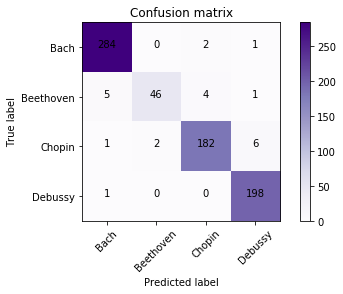

[[265   6  12   4]
 [  4  37  12   3]
 [  3   7 173   8]
 [  1   0   9 189]]


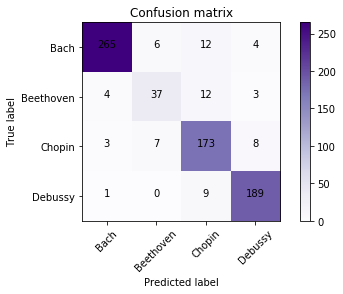

[[287   0   0   0]
 [ 12  38   6   0]
 [ 27   1 158   5]
 [  3   9   2 185]]


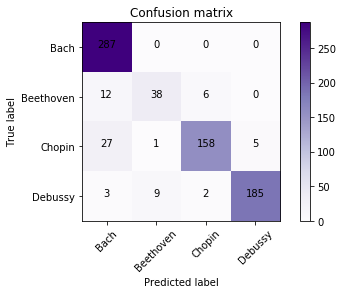

[[251  12   2  22]
 [  3  50   3   0]
 [ 11   2 161  17]
 [  1   4   5 189]]


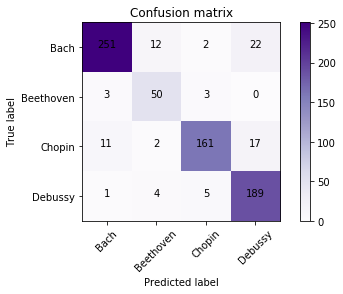

[[281   2   3   1]
 [  2  44   9   1]
 [  5   4 179   3]
 [  3   0   4 192]]


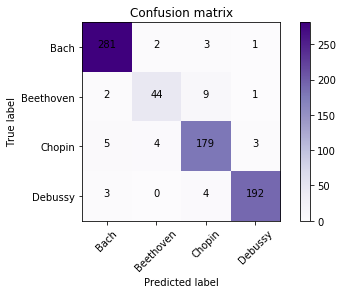

LinearSVC
[[284   0   2   1]
 [  5  46   4   1]
 [  1   2 182   6]
 [  1   0   0 198]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9687 (0.0249) & 0.9499 (0.0479)
LogisticRegression
[[265   6  12   4]
 [  4  37  12   3]
 [  3   7 173   8]
 [  1   0   9 189]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9058 (0.0221) & 0.8572 (0.0401)
KNeighborsClassifier
[[287   0   0   0]
 [ 12  38   6   0]
 [ 27   1 158   5]
 [  3   9   2 185]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9114 (0.0352) & 0.8778 (0.0487)
MultinomialNB
[[251  12   2  22]
 [  3  50   3   0]
 [ 11   2 161  17]
 [  1   4   5 189]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8882 (0.0209) & 0.8722 (0.0305)
MLPClassifier
[[281   2   3   1]
 [  2  44   9   1]
 [  5   4 179   3]
 [  3   0   4 192]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9496 (0.0222) & 0.9241 (0.0399)
n-gram range (2, 2)
[[286   0   1   0]
 [  8  37  10   1]
 [  4   0

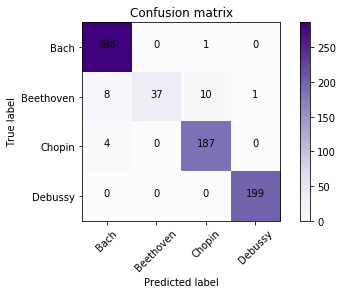

[[275   5   4   3]
 [ 11  29  14   2]
 [ 11   1 168  11]
 [  0   0   2 197]]


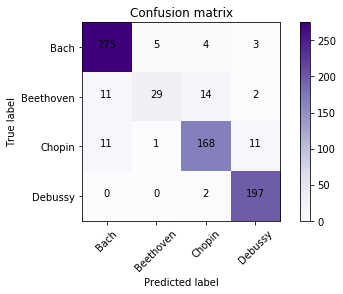

[[286   0   1   0]
 [ 28  24   4   0]
 [ 63   8 117   3]
 [  5   1   1 192]]


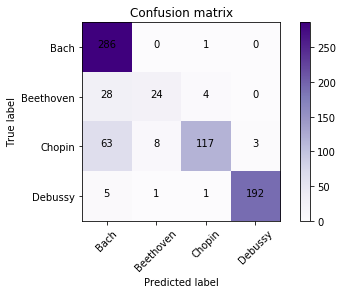

[[276   4   5   2]
 [ 14  25  17   0]
 [ 24   0 162   5]
 [  4   0   8 187]]


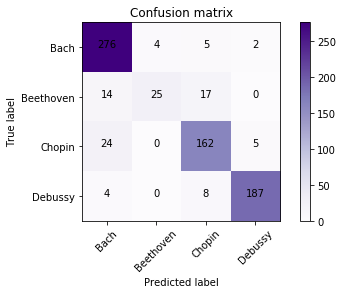

[[280   3   4   0]
 [ 13  26  17   0]
 [  8   9 170   4]
 [  1   7   5 186]]


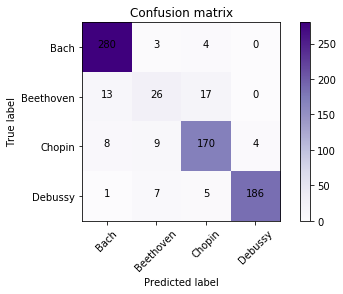

LinearSVC
[[286   0   1   0]
 [  8  37  10   1]
 [  4   0 187   0]
 [  0   0   0 199]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9672 (0.0196) & 0.9123 (0.0693)
LogisticRegression
[[275   5   4   3]
 [ 11  29  14   2]
 [ 11   1 168  11]
 [  0   0   2 197]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9126 (0.0311) & 0.8272 (0.0839)
KNeighborsClassifier
[[286   0   1   0]
 [ 28  24   4   0]
 [ 63   8 117   3]
 [  5   1   1 192]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8445 (0.0496) & 0.7706 (0.0889)
MultinomialNB
[[276   4   5   2]
 [ 14  25  17   0]
 [ 24   0 162   5]
 [  4   0   8 187]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8867 (0.0261) & 0.81 (0.0581)
MLPClassifier
[[280   3   4   0]
 [ 13  26  17   0]
 [  8   9 170   4]
 [  1   7   5 186]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9031 (0.0474) & 0.8332 (0.0645)
n-gram range (3, 3)
[[281   0   4   2]
 [ 25  15  14   2]
 [ 32   0 1

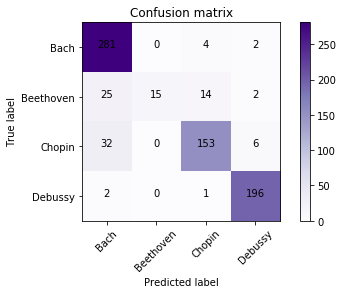

[[272   0  13   2]
 [ 32   0  21   3]
 [ 47   0 133  11]
 [  7   0   1 191]]


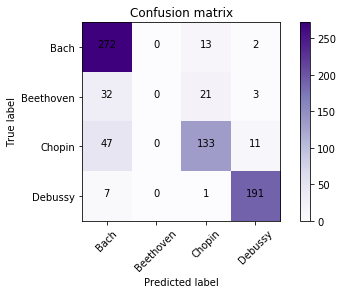

[[266   5  13   3]
 [ 14  31   9   2]
 [ 30   9 145   7]
 [  4   1   3 191]]


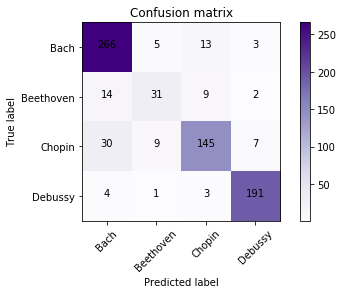

[[285   0   2   0]
 [ 24  20  11   1]
 [ 64   3 118   6]
 [  4   0   1 194]]


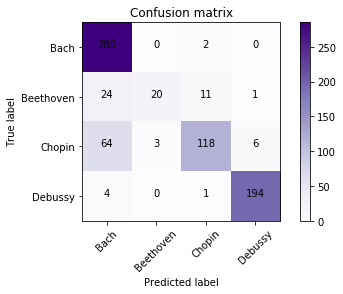

[[251  19  15   2]
 [  8  31  15   2]
 [ 28  49 109   5]
 [  0   7   4 188]]


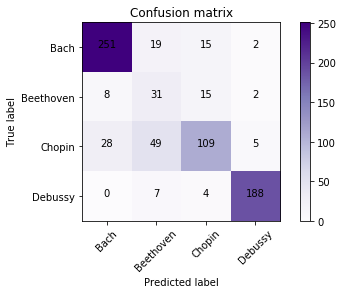

LinearSVC
[[281   0   4   2]
 [ 25  15  14   2]
 [ 32   0 153   6]
 [  2   0   1 196]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8798 (0.0419) & 0.7709 (0.0812)
LogisticRegression
[[272   0  13   2]
 [ 32   0  21   3]
 [ 47   0 133  11]
 [  7   0   1 191]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8131 (0.0482) & 0.6314 (0.0297)
KNeighborsClassifier
[[266   5  13   3]
 [ 14  31   9   2]
 [ 30   9 145   7]
 [  4   1   3 191]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8635 (0.029) & 0.792 (0.0549)
MultinomialNB
[[285   0   2   0]
 [ 24  20  11   1]
 [ 64   3 118   6]
 [  4   0   1 194]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8416 (0.0452) & 0.7623 (0.0758)
MLPClassifier
[[251  19  15   2]
 [  8  31  15   2]
 [ 28  49 109   5]
 [  0   7   4 188]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.7897 (0.0931) & 0.708 (0.1082)
n-gram range (4, 4)
[[268   0  15   4]
 [ 26   8  15   7]
 [ 69   0 11

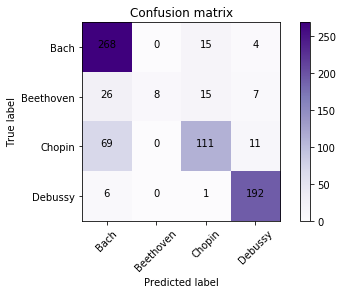

[[269   0  12   6]
 [ 35   0  14   7]
 [ 96   0  82  13]
 [ 20   0   2 177]]


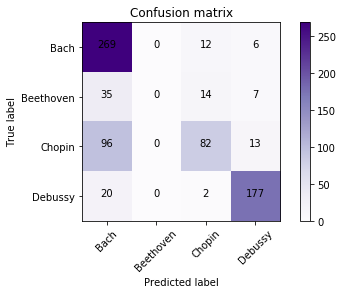

[[211   4  59  13]
 [  7  25  12  12]
 [ 22   2 148  19]
 [  1   1   6 191]]


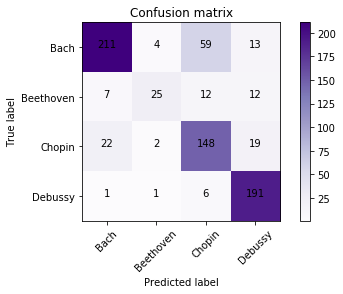

[[271   5   7   4]
 [  9  37   6   4]
 [ 43   9 127  12]
 [  2   2   2 193]]


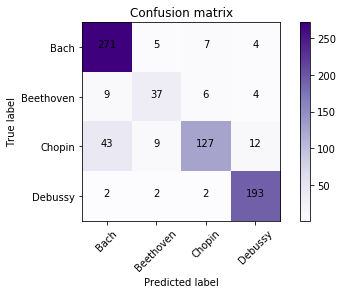

[[159  40  53  35]
 [ 11  14  23   8]
 [ 32  16 116  27]
 [  5   6   7 181]]


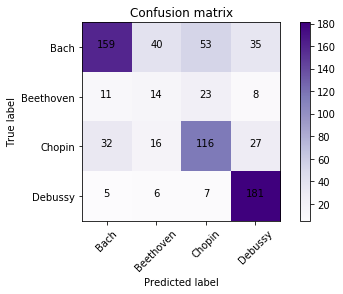

LinearSVC
[[268   0  15   4]
 [ 26   8  15   7]
 [ 69   0 111  11]
 [  6   0   1 192]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.79 (0.0402) & 0.6592 (0.0624)
LogisticRegression
[[269   0  12   6]
 [ 35   0  14   7]
 [ 96   0  82  13]
 [ 20   0   2 177]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.7204 (0.0629) & 0.5459 (0.0535)
KNeighborsClassifier
[[211   4  59  13]
 [  7  25  12  12]
 [ 22   2 148  19]
 [  1   1   6 191]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.7844 (0.0571) & 0.7181 (0.0888)
MultinomialNB
[[271   5   7   4]
 [  9  37   6   4]
 [ 43   9 127  12]
 [  2   2   2 193]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8567 (0.0452) & 0.8042 (0.0704)
MLPClassifier
[[159  40  53  35]
 [ 11  14  23   8]
 [ 32  16 116  27]
 [  5   6   7 181]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.641 (0.0681) & 0.5548 (0.0901)
n-gram range (1, 2)
[[286   0   1   0]
 [  3  44   8   1]
 [  2   0 18

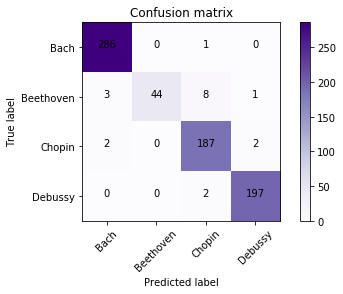

[[272   6   8   1]
 [ 12  29  12   3]
 [ 10   2 172   7]
 [  2   1   7 189]]


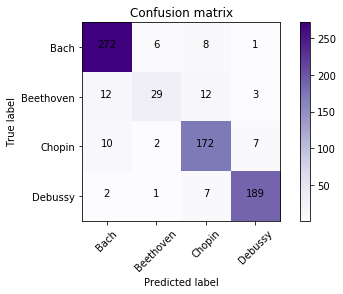

[[287   0   0   0]
 [ 25  27   3   1]
 [ 53   3 132   3]
 [  5   1   1 192]]


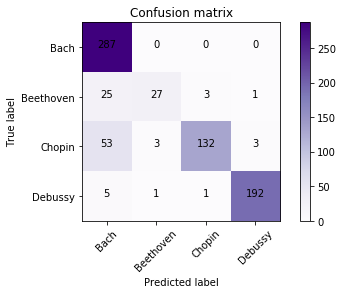

[[276   3   3   5]
 [ 14  22  20   0]
 [ 26   0 161   4]
 [  6   1   7 185]]


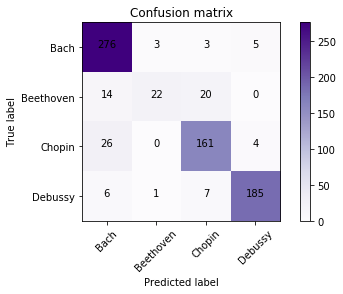

[[276   9   1   1]
 [ 10  37   7   2]
 [  3   7 179   2]
 [  0   3   7 189]]


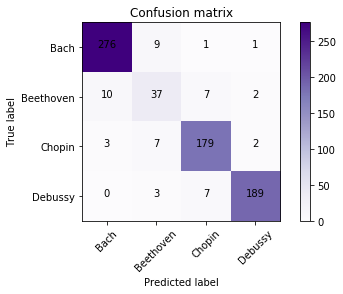

LinearSVC
[[286   0   1   0]
 [  3  44   8   1]
 [  2   0 187   2]
 [  0   0   2 197]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9741 (0.0135) & 0.954 (0.0278)
LogisticRegression
[[272   6   8   1]
 [ 12  29  12   3]
 [ 10   2 172   7]
 [  2   1   7 189]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9031 (0.0238) & 0.8197 (0.0798)
KNeighborsClassifier
[[287   0   0   0]
 [ 25  27   3   1]
 [ 53   3 132   3]
 [  5   1   1 192]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8704 (0.0237) & 0.8049 (0.0469)
MultinomialNB
[[276   3   3   5]
 [ 14  22  20   0]
 [ 26   0 161   4]
 [  6   1   7 185]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8786 (0.0388) & 0.7902 (0.0886)
MLPClassifier
[[276   9   1   1]
 [ 10  37   7   2]
 [  3   7 179   2]
 [  0   3   7 189]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9291 (0.0367) & 0.8724 (0.0708)
n-gram range (3, 4)
[[277   0   7   3]
 [ 22  10  18   6]
 [ 40   0 

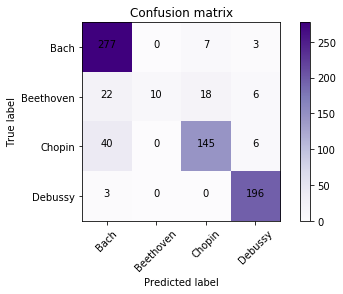

[[267   0  16   4]
 [ 33   0  19   4]
 [ 74   0 108   9]
 [ 12   0   2 185]]


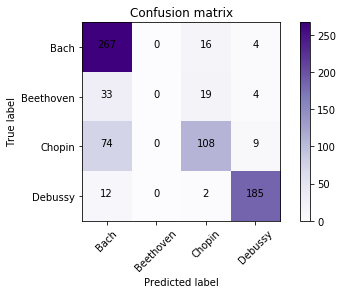

[[254   4  24   5]
 [ 13  25  14   4]
 [ 34  11 133  13]
 [  4   0   5 190]]


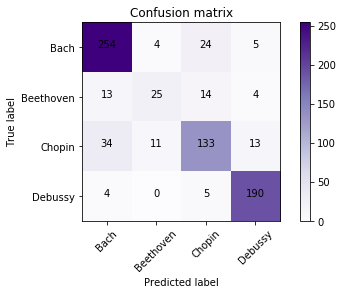

[[284   0   3   0]
 [ 20  26   9   1]
 [ 60   2 123   6]
 [  2   0   1 196]]


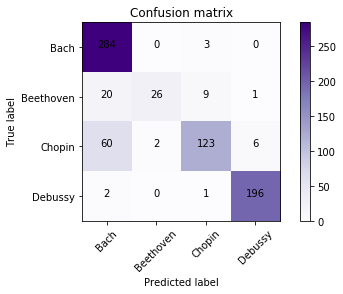

[[227  28  20  12]
 [  9  24  13  10]
 [ 25  51 108   7]
 [  9  12   3 175]]


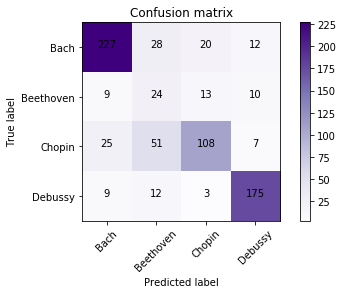

LinearSVC
[[277   0   7   3]
 [ 22  10  18   6]
 [ 40   0 145   6]
 [  3   0   0 196]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8567 (0.0292) & 0.7315 (0.0488)
LogisticRegression
[[267   0  16   4]
 [ 33   0  19   4]
 [ 74   0 108   9]
 [ 12   0   2 185]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.7638 (0.0501) & 0.5845 (0.0436)
KNeighborsClassifier
[[254   4  24   5]
 [ 13  25  14   4]
 [ 34  11 133  13]
 [  4   0   5 190]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8213 (0.0445) & 0.7508 (0.0617)
MultinomialNB
[[284   0   3   0]
 [ 20  26   9   1]
 [ 60   2 123   6]
 [  2   0   1 196]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8581 (0.041) & 0.7901 (0.0754)
MLPClassifier
[[227  28  20  12]
 [  9  24  13  10]
 [ 25  51 108   7]
 [  9  12   3 175]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.7281 (0.0948) & 0.6544 (0.1049)
n-gram range (1, 4)
[[283   0   4   0]
 [ 13  26  13   4]
 [ 12   0 

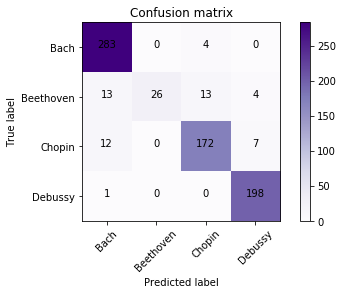

[[263   0  15   9]
 [ 20   0  33   3]
 [ 24   0 159   8]
 [  1   0   9 189]]


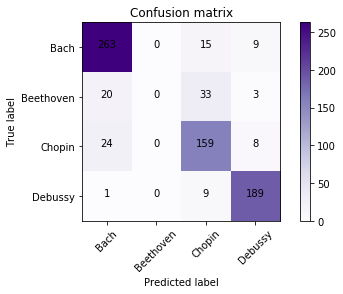

[[285   0   2   0]
 [ 21  28   6   1]
 [ 41   6 139   5]
 [  1   0   4 194]]


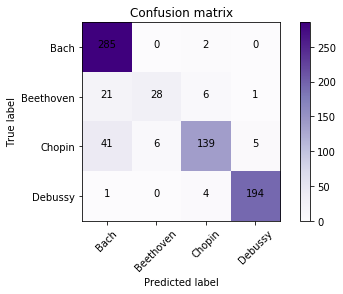

[[283   0   4   0]
 [ 20  23  13   0]
 [ 38   0 147   6]
 [  3   0   2 194]]


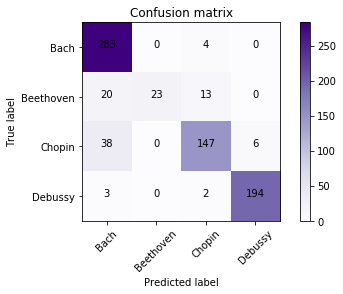

[[254  14  11   8]
 [ 13  26  14   3]
 [ 16  25 142   8]
 [  1   2   1 195]]


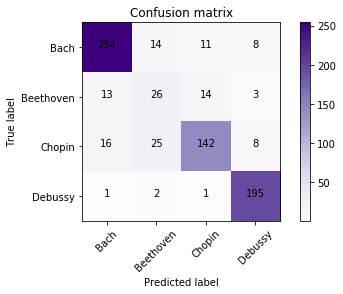

LinearSVC
[[283   0   4   0]
 [ 13  26  13   4]
 [ 12   0 172   7]
 [  1   0   0 198]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9263 (0.0331) & 0.8618 (0.0886)
LogisticRegression
[[263   0  15   9]
 [ 20   0  33   3]
 [ 24   0 159   8]
 [  1   0   9 189]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8336 (0.0416) & 0.6473 (0.0247)
KNeighborsClassifier
[[285   0   2   0]
 [ 21  28   6   1]
 [ 41   6 139   5]
 [  1   0   4 194]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8813 (0.0492) & 0.8302 (0.0737)
MultinomialNB
[[283   0   4   0]
 [ 20  23  13   0]
 [ 38   0 147   6]
 [  3   0   2 194]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8827 (0.0387) & 0.8184 (0.0817)
MLPClassifier
[[254  14  11   8]
 [ 13  26  14   3]
 [ 16  25 142   8]
 [  1   2   1 195]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8419 (0.0436) & 0.7616 (0.0602)

-----


['bach_xml130.xml',
 'bach_xml241.xml',
 'bach_xml54.xml',
 'beethoven_xml2.xml',
 'beethoven_xml28.xml',
 'beethoven_xml3.xml',
 'beethoven_xml30.xml',
 'beethoven_xml31.xml',
 'beethoven_xml34.xml',
 'beethoven_xml36.xml',
 'beethoven_xml46.xml',
 'beethoven_xml52.xml',
 'beethoven_xml9.xml',
 'chopin_xml106.xml',
 'chopin_xml123.xml',
 'chopin_xml27.xml',
 'chopin_xml64.xml',
 'chopin_xml68.xml',
 'chopin_xml77.xml',
 'chopin_xml8.xml',
 'chopin_xml81.xml',
 'chopin_xml84.xml',
 'debussy_images_oubliee_1_(c)lefeldt.mxl',
 'bach_xml0.xml',
 'bach_xml117.xml',
 'bach_xml125.xml',
 'bach_xml13.xml',
 'bach_xml130.xml',
 'bach_xml139.xml',
 'bach_xml140.xml',
 'bach_xml144.xml',
 'bach_xml15.xml',
 'bach_xml240.xml',
 'bach_xml241.xml',
 'bach_xml244.xml',
 'bach_xml254.xml',
 'bach_xml286.xml',
 'bach_xml33.xml',
 'bach_xml35.xml',
 'bach_xml4.xml',
 'bach_xml41.xml',
 'bach_xml5.xml',
 'bach_xml53.xml',
 'bach_xml55.xml',
 'bach_xml6.xml',
 'beethoven_xml12.xml',
 'beethoven_xml19.xml

In [19]:
VECTORIZER = TfidfVectorizer(sublinear_tf=True)
benchmark_classifiers(COMPOSERS,NGRAMRANGES,CLASSIFIERS,VECTORIZER)

n-gram range (1, 1)
[[271   1   8   7]
 [  4  42   8   2]
 [ 15   4 166   6]
 [  5   1   4 189]]


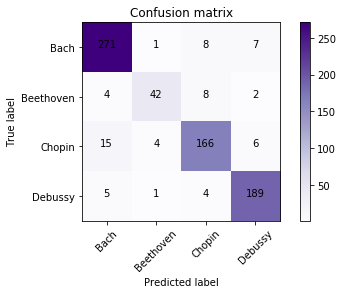

[[253   4  12  18]
 [  3  27  21   5]
 [ 19  11 150  11]
 [  6   3  14 176]]


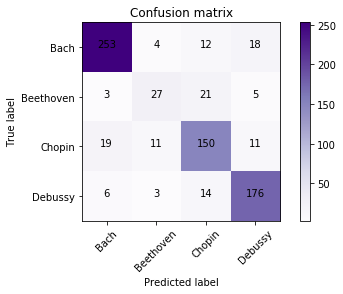

[[282   0   1   4]
 [ 12  35   7   2]
 [ 33   2 148   8]
 [  7   1   7 184]]


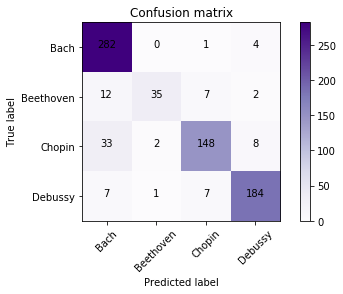

[[250   6   1  30]
 [  1  48   4   3]
 [ 12   5 155  19]
 [  0   5   6 188]]


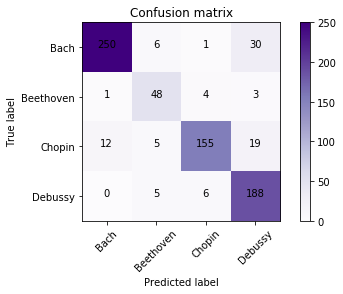

[[276   2   6   3]
 [  4  41  10   1]
 [ 11   8 167   5]
 [  4   3   7 185]]


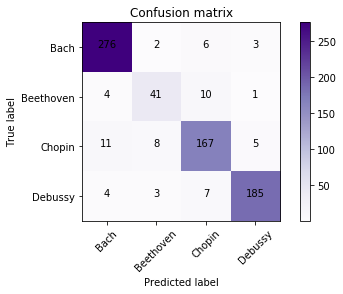

LinearSVC
[[271   1   8   7]
 [  4  42   8   2]
 [ 15   4 166   6]
 [  5   1   4 189]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9112 (0.0395) & 0.881 (0.0577)
LogisticRegression
[[253   4  12  18]
 [  3  27  21   5]
 [ 19  11 150  11]
 [  6   3  14 176]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8266 (0.0582) & 0.745 (0.0941)
KNeighborsClassifier
[[282   0   1   4]
 [ 12  35   7   2]
 [ 33   2 148   8]
 [  7   1   7 184]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8853 (0.0328) & 0.8379 (0.0608)
MultinomialNB
[[250   6   1  30]
 [  1  48   4   3]
 [ 12   5 155  19]
 [  0   5   6 188]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8744 (0.0403) & 0.8537 (0.0443)
MLPClassifier
[[276   2   6   3]
 [  4  41  10   1]
 [ 11   8 167   5]
 [  4   3   7 185]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9126 (0.0306) & 0.8732 (0.0572)
n-gram range (2, 2)
[[279   0   8   0]
 [ 14  26  15   1]
 [  5   0 1

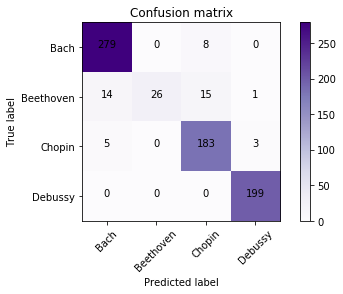

[[240   0  21  26]
 [ 13   3  33   7]
 [ 21   0 149  21]
 [  2   0   2 195]]


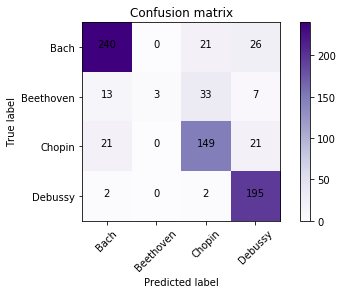

[[ 60   0 227   0]
 [  3   0  53   0]
 [  0   0 191   0]
 [  0   0 180  19]]


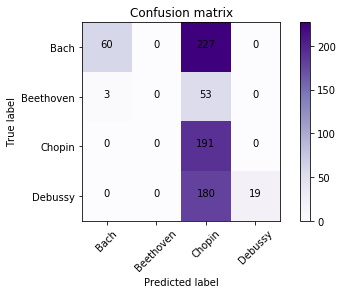

[[278   2   4   3]
 [ 19  14  23   0]
 [ 33   0 154   4]
 [  6   1  10 182]]


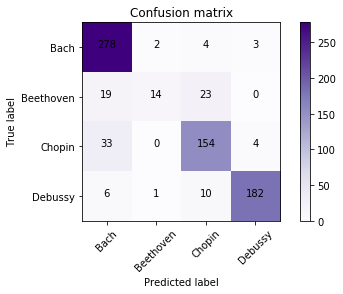

[[277   6   4   0]
 [  6  35  13   2]
 [  3  10 177   1]
 [  0   0   7 192]]


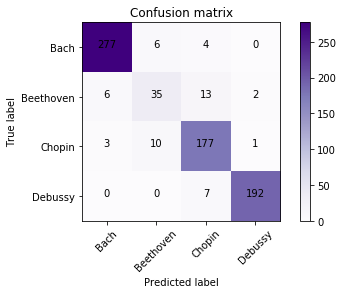

LinearSVC
[[279   0   8   0]
 [ 14  26  15   1]
 [  5   0 183   3]
 [  0   0   0 199]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9372 (0.0393) & 0.8789 (0.0652)
LogisticRegression
[[240   0  21  26]
 [ 13   3  33   7]
 [ 21   0 149  21]
 [  2   0   2 195]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8009 (0.043) & 0.6385 (0.0311)
KNeighborsClassifier
[[ 60   0 227   0]
 [  3   0  53   0]
 [  0   0 191   0]
 [  0   0 180  19]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.3683 (0.0593) & 0.2356 (0.0455)
MultinomialNB
[[278   2   4   3]
 [ 19  14  23   0]
 [ 33   0 154   4]
 [  6   1  10 182]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8568 (0.034) & 0.7489 (0.0444)
MLPClassifier
[[277   6   4   0]
 [  6  35  13   2]
 [  3  10 177   1]
 [  0   0   7 192]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.929 (0.0321) & 0.871 (0.0394)
n-gram range (3, 3)
[[266   0  17   4]
 [ 22   5  20   9]
 [ 21   0 163

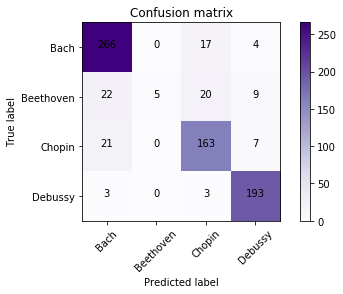

[[275   0   7   5]
 [ 41   0  13   2]
 [ 99   0  84   8]
 [ 28   0   0 171]]


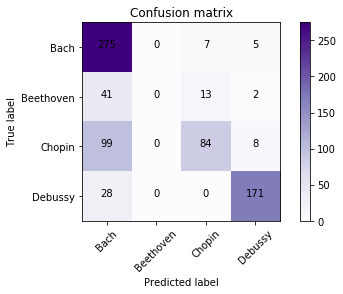

[[  6   0 281   0]
 [  0   0  56   0]
 [  0   0 191   0]
 [  0   0 196   3]]


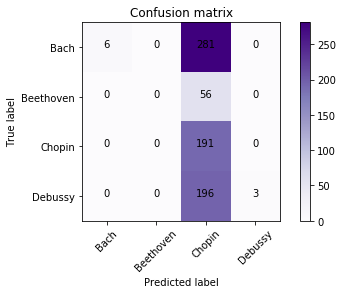

[[285   0   2   0]
 [ 27  17  11   1]
 [ 71   1 112   7]
 [  7   0   2 190]]


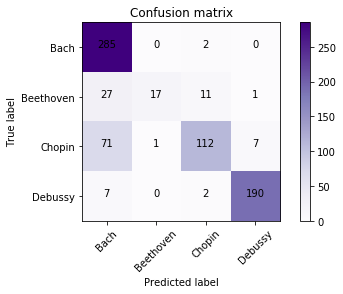

[[262   0  22   3]
 [ 23   5  24   4]
 [ 32   1 153   5]
 [  5   0   7 187]]


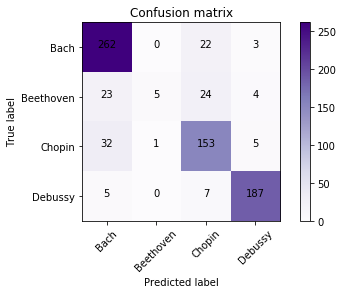

LinearSVC
[[266   0  17   4]
 [ 22   5  20   9]
 [ 21   0 163   7]
 [  3   0   3 193]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8555 (0.029) & 0.699 (0.0649)
LogisticRegression
[[275   0   7   5]
 [ 41   0  13   2]
 [ 99   0  84   8]
 [ 28   0   0 171]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.7231 (0.0454) & 0.55 (0.0433)
KNeighborsClassifier
[[  6   0 281   0]
 [  0   0  56   0]
 [  0   0 191   0]
 [  0   0 196   3]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.2729 (0.0722) & 0.1209 (0.0326)
MultinomialNB
[[285   0   2   0]
 [ 27  17  11   1]
 [ 71   1 112   7]
 [  7   0   2 190]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8241 (0.041) & 0.7302 (0.0648)
MLPClassifier
[[262   0  22   3]
 [ 23   5  24   4]
 [ 32   1 153   5]
 [  5   0   7 187]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8281 (0.0375) & 0.6797 (0.0683)
n-gram range (4, 4)
[[256   0  27   4]
 [ 24   0  24   8]
 [ 62   0 121 

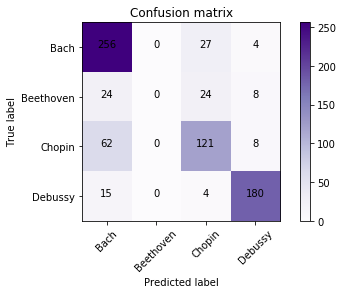

[[255   0  17  15]
 [ 26   6  13  11]
 [ 80   0  94  17]
 [ 17   0   2 180]]


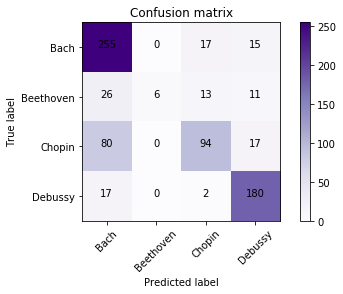

[[  8   0 279   0]
 [  0   0  56   0]
 [  0   0 191   0]
 [  0   0 198   1]]


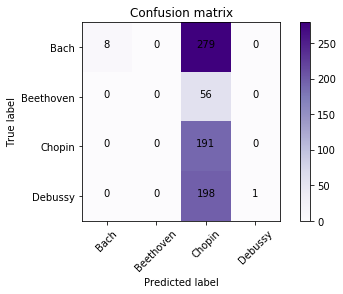

[[268   2  12   5]
 [ 11  31  10   4]
 [ 45   7 129  10]
 [  3   0   1 195]]


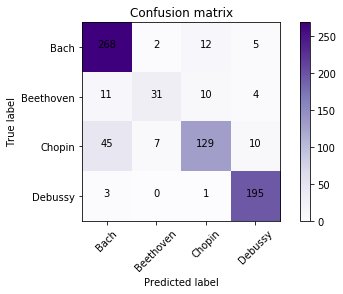

[[228   0  53   6]
 [ 15   0  35   6]
 [ 45   0 141   5]
 [ 13   0  13 173]]


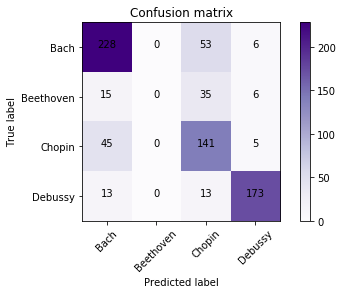

LinearSVC
[[256   0  27   4]
 [ 24   0  24   8]
 [ 62   0 121   8]
 [ 15   0   4 180]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.7599 (0.0493) & 0.5867 (0.0364)
LogisticRegression
[[255   0  17  15]
 [ 26   6  13  11]
 [ 80   0  94  17]
 [ 17   0   2 180]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.7299 (0.0601) & 0.595 (0.0779)
KNeighborsClassifier
[[  8   0 279   0]
 [  0   0  56   0]
 [  0   0 191   0]
 [  0   0 198   1]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.2729 (0.0517) & 0.1182 (0.0176)
MultinomialNB
[[268   2  12   5]
 [ 11  31  10   4]
 [ 45   7 129  10]
 [  3   0   1 195]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.85 (0.0262) & 0.7954 (0.0384)
MLPClassifier
[[228   0  53   6]
 [ 15   0  35   6]
 [ 45   0 141   5]
 [ 13   0  13 173]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.7394 (0.0684) & 0.5748 (0.0441)
n-gram range (1, 2)
[[284   0   1   2]
 [ 12  30  13   1]
 [  3   0 18

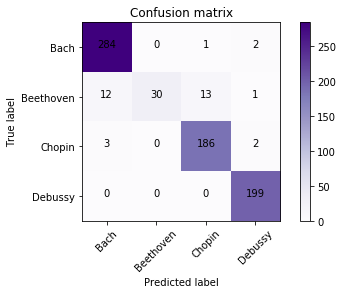

[[253   2   8  24]
 [ 19   8  25   4]
 [ 29   0 139  23]
 [  2   0   2 195]]


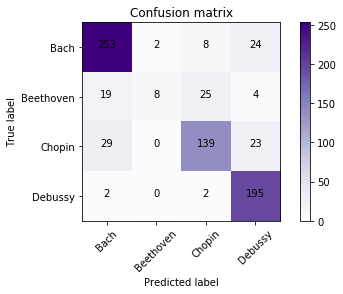

[[138   0 149   0]
 [ 13   0  41   2]
 [  4   0 187   0]
 [  0   0 151  48]]


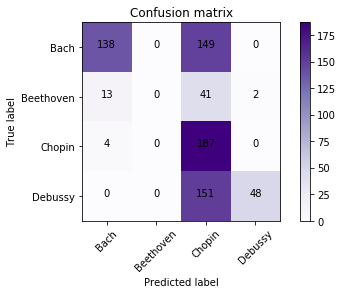

[[276   4   3   4]
 [ 17  14  25   0]
 [ 25   0 161   5]
 [  9   0   9 181]]


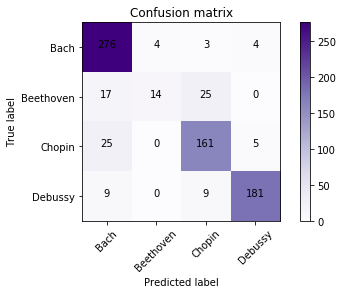

[[283   1   2   1]
 [  7  37  11   1]
 [  2  13 170   6]
 [  4   3   4 188]]


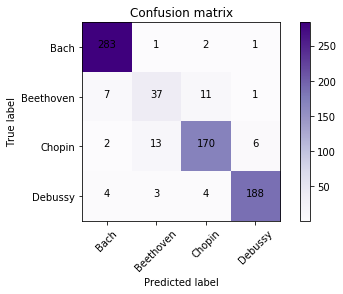

LinearSVC
[[284   0   1   2]
 [ 12  30  13   1]
 [  3   0 186   2]
 [  0   0   0 199]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9536 (0.0304) & 0.8992 (0.0694)
LogisticRegression
[[253   2   8  24]
 [ 19   8  25   4]
 [ 29   0 139  23]
 [  2   0   2 195]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8117 (0.0533) & 0.6699 (0.0684)
KNeighborsClassifier
[[138   0 149   0]
 [ 13   0  41   2]
 [  4   0 187   0]
 [  0   0 151  48]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.5087 (0.0578) & 0.3788 (0.043)
MultinomialNB
[[276   4   3   4]
 [ 17  14  25   0]
 [ 25   0 161   5]
 [  9   0   9 181]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8622 (0.0476) & 0.7572 (0.0704)
MLPClassifier
[[283   1   2   1]
 [  7  37  11   1]
 [  2  13 170   6]
 [  4   3   4 188]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.925 (0.0252) & 0.8804 (0.0434)
n-gram range (3, 4)
[[262   0  20   5]
 [ 22   0  24  10]
 [ 25   0 1

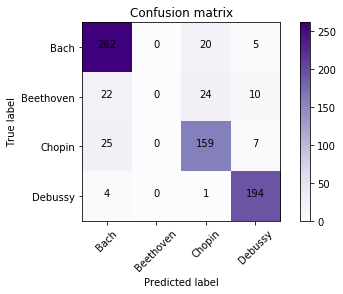

[[273   1   7   6]
 [ 44   0  10   2]
 [109   0  76   6]
 [ 28   0   1 170]]


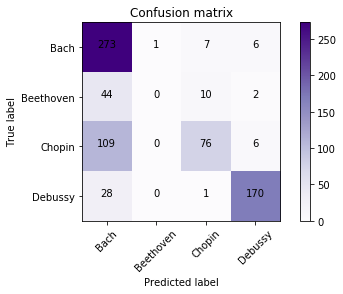

[[  6   0 281   0]
 [  0   0  56   0]
 [  0   0 191   0]
 [  0   0 197   2]]


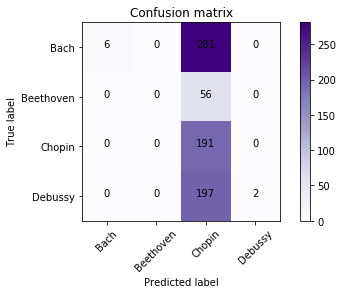

[[283   0   4   0]
 [ 25  20  10   1]
 [ 67   1 117   6]
 [  4   0   1 194]]


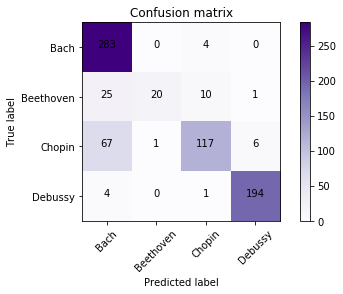

[[265   0  17   5]
 [ 27   1  27   1]
 [ 41   0 145   5]
 [  8   0   4 187]]


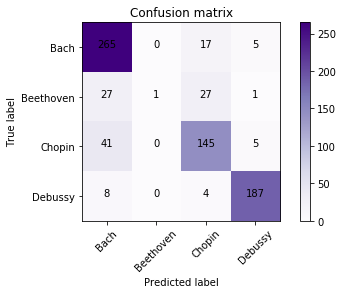

LinearSVC
[[262   0  20   5]
 [ 22   0  24  10]
 [ 25   0 159   7]
 [  4   0   1 194]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8389 (0.0617) & 0.6497 (0.0405)
LogisticRegression
[[273   1   7   6]
 [ 44   0  10   2]
 [109   0  76   6]
 [ 28   0   1 170]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.708 (0.0621) & 0.5355 (0.052)
KNeighborsClassifier
[[  6   0 281   0]
 [  0   0  56   0]
 [  0   0 191   0]
 [  0   0 197   2]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.2715 (0.0599) & 0.1182 (0.0211)
MultinomialNB
[[283   0   4   0]
 [ 25  20  10   1]
 [ 67   1 117   6]
 [  4   0   1 194]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8377 (0.0412) & 0.7475 (0.0795)
MLPClassifier
[[265   0  17   5]
 [ 27   1  27   1]
 [ 41   0 145   5]
 [  8   0   4 187]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8157 (0.0609) & 0.6388 (0.0436)
n-gram range (1, 4)
[[280   0   6   1]
 [ 23   9  21   3]
 [ 10   0 1

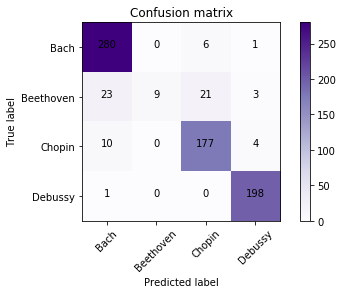

[[265   0  10  12]
 [ 34   0  20   2]
 [ 73   0 101  17]
 [ 11   0   1 187]]


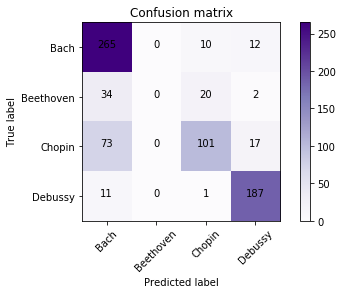

[[  9   0 278   0]
 [  0   0  56   0]
 [  0   0 191   0]
 [  0   0 197   2]]


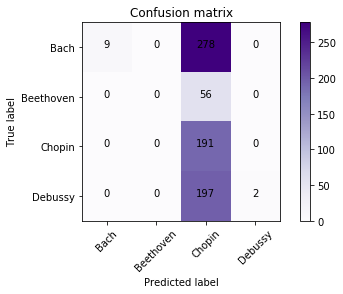

[[283   0   4   0]
 [ 24  19  13   0]
 [ 48   0 137   6]
 [  2   0   4 193]]


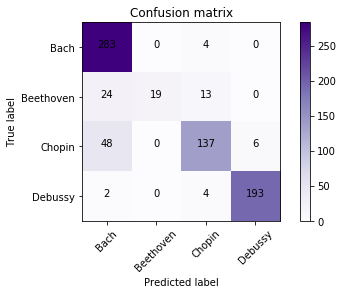

[[268   5  12   2]
 [ 14  26  14   2]
 [ 10   1 173   7]
 [  1   0   7 191]]


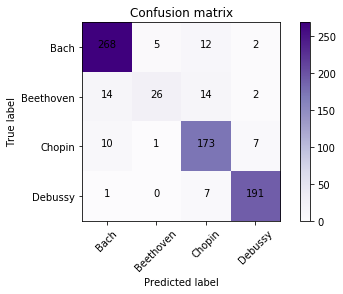

LinearSVC
[[280   0   6   1]
 [ 23   9  21   3]
 [ 10   0 177   4]
 [  1   0   0 198]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.906 (0.0466) & 0.7621 (0.0701)
LogisticRegression
[[265   0  10  12]
 [ 34   0  20   2]
 [ 73   0 101  17]
 [ 11   0   1 187]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.7546 (0.0872) & 0.5722 (0.0684)
KNeighborsClassifier
[[  9   0 278   0]
 [  0   0  56   0]
 [  0   0 191   0]
 [  0   0 197   2]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.2758 (0.0652) & 0.1233 (0.0333)
MultinomialNB
[[283   0   4   0]
 [ 24  19  13   0]
 [ 48   0 137   6]
 [  2   0   4 193]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8623 (0.0527) & 0.7631 (0.0591)
MLPClassifier
[[268   5  12   2]
 [ 14  26  14   2]
 [ 10   1 173   7]
 [  1   0   7 191]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8978 (0.0448) & 0.8082 (0.079)

-----


['bach_xml10.xml',
 'bach_xml13.xml',
 'bach_xml130.xml',
 'bach_xml139.xml',
 'bach_xml144.xml',
 'bach_xml15.xml',
 'bach_xml17.xml',
 'bach_xml196.xml',
 'bach_xml237.xml',
 'bach_xml240.xml',
 'bach_xml241.xml',
 'bach_xml275.xml',
 'bach_xml40.xml',
 'bach_xml43.xml',
 'bach_xml54.xml',
 'bach_xml77.xml',
 'beethoven_xml3.xml',
 'beethoven_xml30.xml',
 'beethoven_xml34.xml',
 'beethoven_xml36.xml',
 'beethoven_xml38.xml',
 'beethoven_xml43.xml',
 'beethoven_xml44.xml',
 'beethoven_xml46.xml',
 'beethoven_xml47.xml',
 'beethoven_xml5.xml',
 'beethoven_xml52.xml',
 'beethoven_xml53.xml',
 'beethoven_xml8.xml',
 'beethoven_xml9.xml',
 'chopin_xml102.xml',
 'chopin_xml142.xml',
 'chopin_xml144.xml',
 'chopin_xml145.xml',
 'chopin_xml154.xml',
 'chopin_xml169.xml',
 'chopin_xml179.xml',
 'chopin_xml183.xml',
 'chopin_xml187.xml',
 'chopin_xml27.xml',
 'chopin_xml32.xml',
 'chopin_xml49.xml',
 'chopin_xml59.xml',
 'chopin_xml61.xml',
 'chopin_xml64.xml',
 'chopin_xml67.xml',
 'chopin_xm

In [20]:
VECTORIZER = CountVectorizer(binary=True)
benchmark_classifiers(COMPOSERS,NGRAMRANGES,CLASSIFIERS,VECTORIZER)

n-gram range (1, 1)
[[273   6   7   1]
 [  9  37   9   1]
 [  8   4 178   1]
 [  4   1   4 190]]


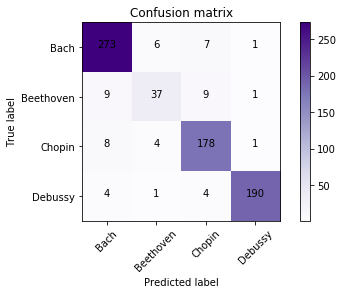

[[259   0  16  12]
 [ 39   0  16   1]
 [ 98   0  90   3]
 [ 73   0   2 124]]


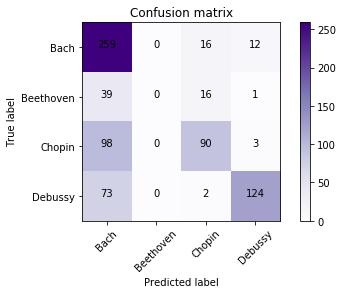

[[260   5  22   0]
 [ 21  16  18   1]
 [ 41   2 144   4]
 [  7   0   9 183]]


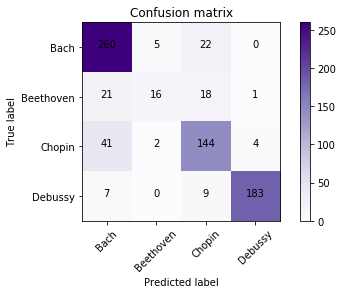

[[209  31  15  32]
 [  3  35  10   8]
 [ 19   9 142  21]
 [  1   5   2 191]]


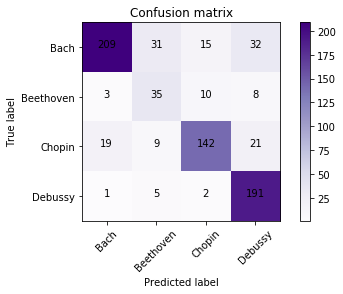

[[266  10   9   2]
 [  7  38  10   1]
 [ 12  11 164   4]
 [  3   0   7 189]]


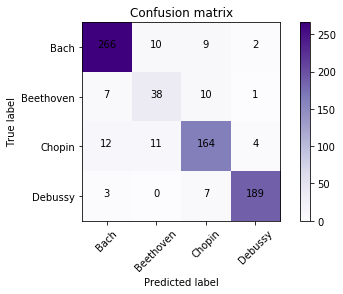

LinearSVC
[[273   6   7   1]
 [  9  37   9   1]
 [  8   4 178   1]
 [  4   1   4 190]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.925 (0.0309) & 0.8782 (0.0543)
LogisticRegression
[[259   0  16  12]
 [ 39   0  16   1]
 [ 98   0  90   3]
 [ 73   0   2 124]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.6455 (0.0586) & 0.4905 (0.0623)
KNeighborsClassifier
[[260   5  22   0]
 [ 21  16  18   1]
 [ 41   2 144   4]
 [  7   0   9 183]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8227 (0.0403) & 0.7304 (0.0654)
MultinomialNB
[[209  31  15  32]
 [  3  35  10   8]
 [ 19   9 142  21]
 [  1   5   2 191]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.7873 (0.0575) & 0.7352 (0.0691)
MLPClassifier
[[266  10   9   2]
 [  7  38  10   1]
 [ 12  11 164   4]
 [  3   0   7 189]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8965 (0.0386) & 0.8517 (0.0693)
n-gram range (2, 2)
[[276   1   8   2]
 [ 10  30  13   3]
 [ 10   1 

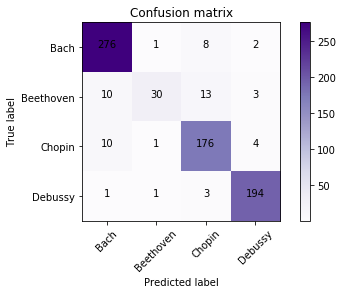

[[266   0  17   4]
 [ 41   0  13   2]
 [135   0  52   4]
 [ 78   0   4 117]]


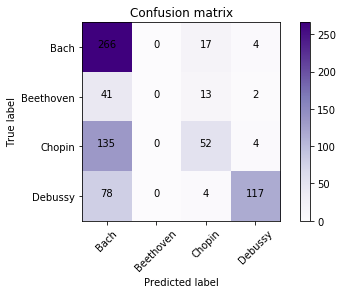

[[162   1 124   0]
 [ 18   2  34   2]
 [ 24   3 158   6]
 [ 11   0  65 123]]


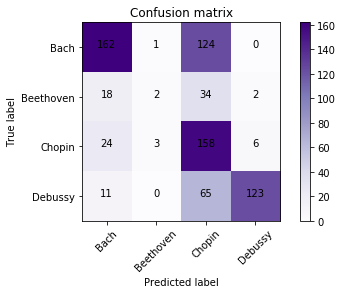

[[271   4   6   6]
 [ 14  18  24   0]
 [ 28   1 156   6]
 [  3   0   7 189]]


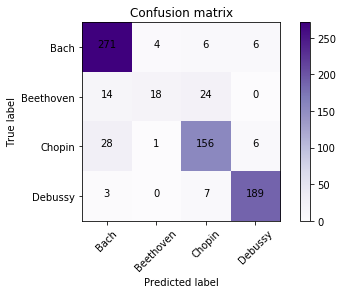

[[270   2  14   1]
 [  8  30  17   1]
 [ 19  10 159   3]
 [  3   0  14 182]]


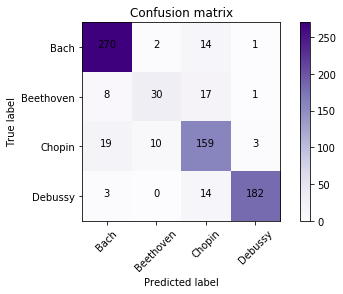

LinearSVC
[[276   1   8   2]
 [ 10  30  13   3]
 [ 10   1 176   4]
 [  1   1   3 194]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9222 (0.0268) & 0.8664 (0.0774)
LogisticRegression
[[266   0  17   4]
 [ 41   0  13   2]
 [135   0  52   4]
 [ 78   0   4 117]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.5935 (0.0571) & 0.4334 (0.0482)
KNeighborsClassifier
[[162   1 124   0]
 [ 18   2  34   2]
 [ 24   3 158   6]
 [ 11   0  65 123]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.6072 (0.0717) & 0.4997 (0.053)
MultinomialNB
[[271   4   6   6]
 [ 14  18  24   0]
 [ 28   1 156   6]
 [  3   0   7 189]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.865 (0.0316) & 0.777 (0.0756)
MLPClassifier
[[270   2  14   1]
 [  8  30  17   1]
 [ 19  10 159   3]
 [  3   0  14 182]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8745 (0.0357) & 0.8185 (0.0578)
n-gram range (3, 3)
[[259   0  25   3]
 [ 16  17  16   7]
 [ 19   2 16

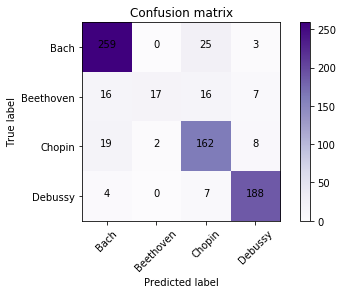

[[246   1  25  15]
 [ 30   2  17   7]
 [114   3  70   4]
 [ 54   0   8 137]]


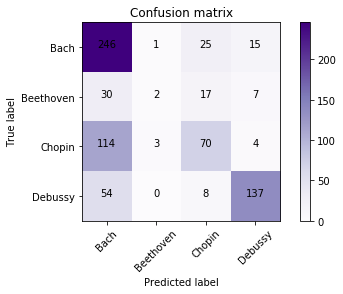

[[ 48   0 231   8]
 [  4   1  48   3]
 [  4   1 179   7]
 [  2   0 140  57]]


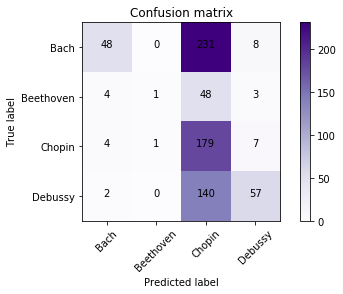

[[285   0   2   0]
 [ 26  18  10   2]
 [ 70   1 113   7]
 [  5   0   2 192]]


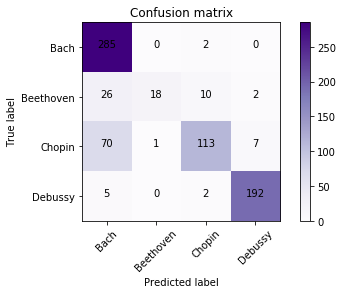

[[250   3  31   3]
 [ 19  22  12   3]
 [ 34  16 133   8]
 [  5   0  14 180]]


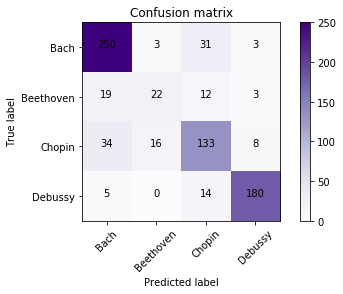

LinearSVC
[[259   0  25   3]
 [ 16  17  16   7]
 [ 19   2 162   8]
 [  4   0   7 188]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8541 (0.0594) & 0.7605 (0.0962)
LogisticRegression
[[246   1  25  15]
 [ 30   2  17   7]
 [114   3  70   4]
 [ 54   0   8 137]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.6207 (0.0846) & 0.472 (0.091)
KNeighborsClassifier
[[ 48   0 231   8]
 [  4   1  48   3]
 [  4   1 179   7]
 [  2   0 140  57]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.3887 (0.0336) & 0.2925 (0.0501)
MultinomialNB
[[285   0   2   0]
 [ 26  18  10   2]
 [ 70   1 113   7]
 [  5   0   2 192]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8296 (0.0337) & 0.7513 (0.053)
MLPClassifier
[[250   3  31   3]
 [ 19  22  12   3]
 [ 34  16 133   8]
 [  5   0  14 180]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.7982 (0.0534) & 0.7272 (0.0726)
n-gram range (4, 4)
[[213   0  66   8]
 [ 20   5  25   6]
 [ 42   1 13

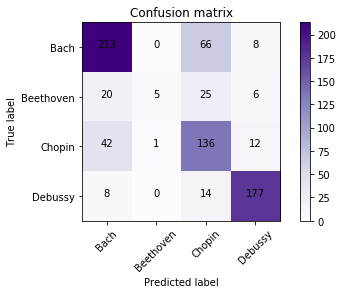

[[229   3  29  26]
 [ 23  10  15   8]
 [ 94  10  62  25]
 [ 40   1  10 148]]


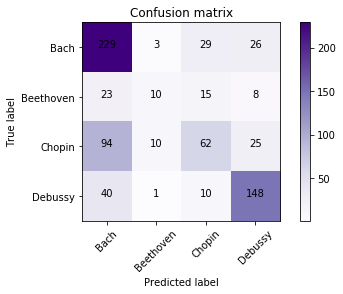

[[ 16   0 265   6]
 [  0   1  52   3]
 [  2   0 182   7]
 [  1   0 172  26]]


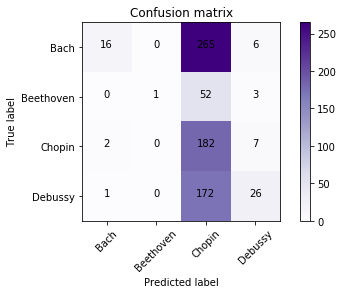

[[268   2  10   7]
 [ 10  35   8   3]
 [ 46   7 125  13]
 [  1   0   2 196]]


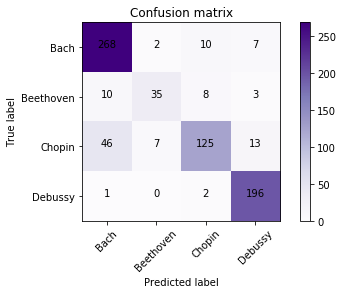

[[191  16  68  12]
 [ 12  21  16   7]
 [ 34   9 138  10]
 [ 13   1  14 171]]


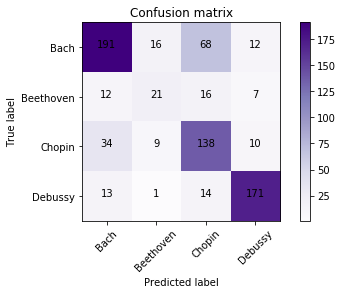

LinearSVC
[[213   0  66   8]
 [ 20   5  25   6]
 [ 42   1 136  12]
 [  8   0  14 177]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.7246 (0.0378) & 0.5964 (0.0599)
LogisticRegression
[[229   3  29  26]
 [ 23  10  15   8]
 [ 94  10  62  25]
 [ 40   1  10 148]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.6127 (0.0726) & 0.493 (0.1059)
KNeighborsClassifier
[[ 16   0 265   6]
 [  0   1  52   3]
 [  2   0 182   7]
 [  1   0 172  26]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.307 (0.0399) & 0.1869 (0.0464)
MultinomialNB
[[268   2  10   7]
 [ 10  35   8   3]
 [ 46   7 125  13]
 [  1   0   2 196]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8514 (0.0375) & 0.8099 (0.0595)
MLPClassifier
[[191  16  68  12]
 [ 12  21  16   7]
 [ 34   9 138  10]
 [ 13   1  14 171]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.7109 (0.0696) & 0.6499 (0.0653)
n-gram range (1, 2)
[[273   4   8   2]
 [  8  38   9   1]
 [ 10   4 1

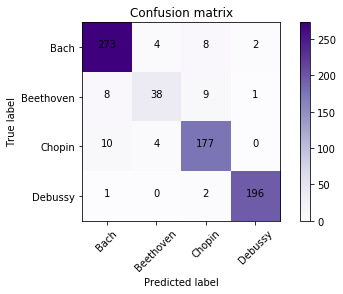

[[271   0  10   6]
 [ 44   0  11   1]
 [116   1  72   2]
 [107   0   4  88]]


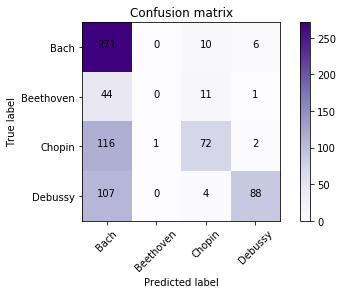

[[260   3  24   0]
 [ 21  12  22   1]
 [ 41   2 147   1]
 [ 16   0  11 172]]


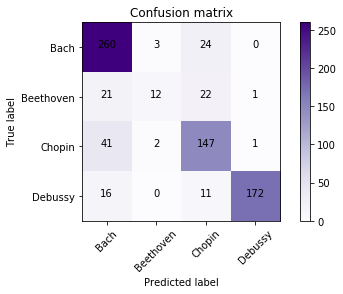

[[265   5   9   8]
 [ 12  25  18   1]
 [ 29   1 151  10]
 [  2   1   8 188]]


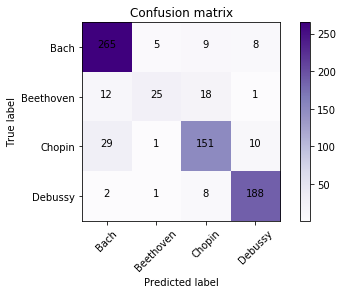

[[269   8   7   3]
 [  4  43   8   1]
 [ 10   6 169   6]
 [  6   0   3 190]]


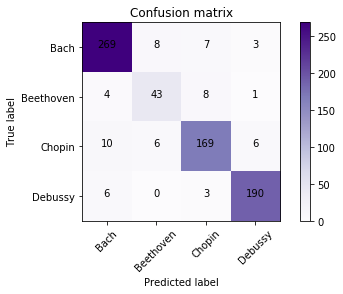

LinearSVC
[[273   4   8   2]
 [  8  38   9   1]
 [ 10   4 177   0]
 [  1   0   2 196]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9331 (0.0405) & 0.8933 (0.0827)
LogisticRegression
[[271   0  10   6]
 [ 44   0  11   1]
 [116   1  72   2]
 [107   0   4  88]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.5877 (0.0928) & 0.4201 (0.0933)
KNeighborsClassifier
[[260   3  24   0]
 [ 21  12  22   1]
 [ 41   2 147   1]
 [ 16   0  11 172]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8063 (0.0517) & 0.7033 (0.0917)
MultinomialNB
[[265   5   9   8]
 [ 12  25  18   1]
 [ 29   1 151  10]
 [  2   1   8 188]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8581 (0.0245) & 0.7907 (0.0476)
MLPClassifier
[[269   8   7   3]
 [  4  43   8   1]
 [ 10   6 169   6]
 [  6   0   3 190]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9153 (0.0398) & 0.8868 (0.0771)
n-gram range (3, 4)
[[257   0  25   5]
 [ 19  13  18   6]
 [ 28   3

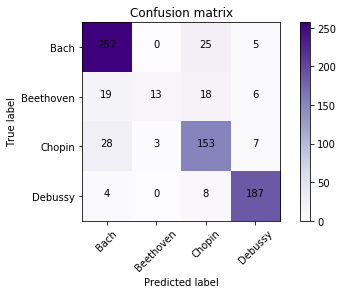

[[239   2  23  23]
 [ 28   4  19   5]
 [ 93   3  78  17]
 [ 49   0   7 143]]


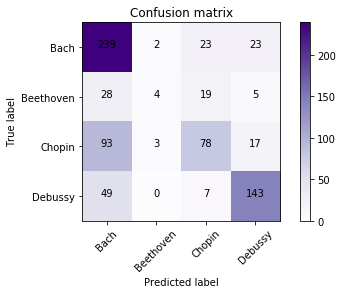

[[ 31   2 248   6]
 [  1   0  51   4]
 [  2   1 181   7]
 [  4   0 158  37]]


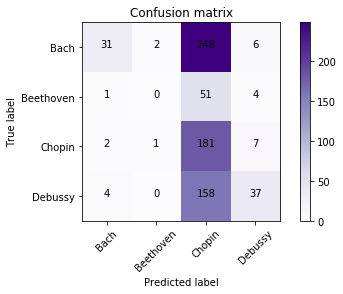

[[281   1   4   1]
 [ 21  20  13   2]
 [ 67   0 117   7]
 [  2   0   1 196]]


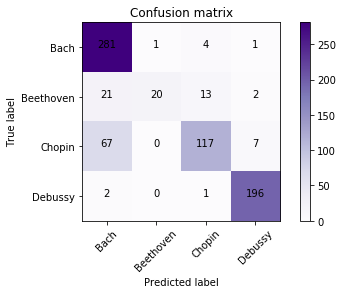

[[230   8  44   5]
 [ 17  19  14   6]
 [ 30   6 150   5]
 [  7   1  13 178]]


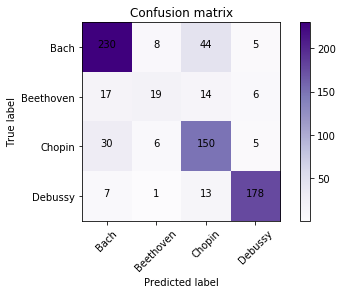

LinearSVC
[[257   0  25   5]
 [ 19  13  18   6]
 [ 28   3 153   7]
 [  4   0   8 187]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8324 (0.0603) & 0.7268 (0.1046)
LogisticRegression
[[239   2  23  23]
 [ 28   4  19   5]
 [ 93   3  78  17]
 [ 49   0   7 143]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.6331 (0.0754) & 0.4892 (0.0861)
KNeighborsClassifier
[[ 31   2 248   6]
 [  1   0  51   4]
 [  2   1 181   7]
 [  4   0 158  37]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.3396 (0.0647) & 0.2278 (0.0384)
MultinomialNB
[[281   1   4   1]
 [ 21  20  13   2]
 [ 67   0 117   7]
 [  2   0   1 196]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8378 (0.0506) & 0.755 (0.0746)
MLPClassifier
[[230   8  44   5]
 [ 17  19  14   6]
 [ 30   6 150   5]
 [  7   1  13 178]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.7872 (0.0665) & 0.7169 (0.0998)
n-gram range (1, 4)
[[276   2   7   2]
 [ 11  33  11   1]
 [  6   1 

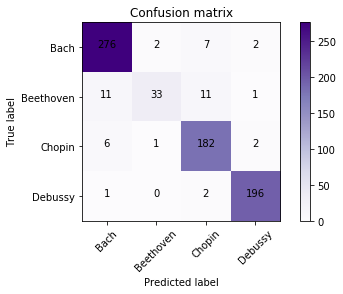

[[280   0   5   2]
 [ 46   1   7   2]
 [147   0  44   0]
 [139   0   1  59]]


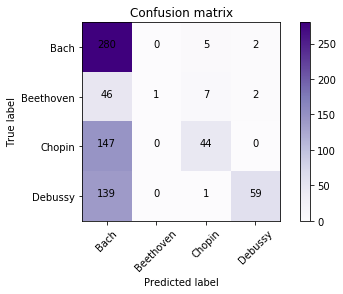

[[252   3  30   2]
 [ 24  11  21   0]
 [ 34   1 153   3]
 [ 11   1  27 160]]


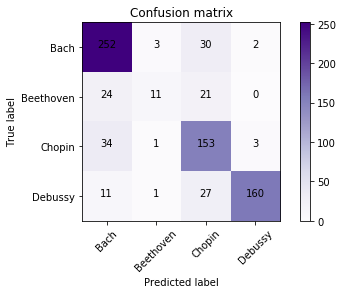

[[280   2   4   1]
 [ 20  21  13   2]
 [ 41   0 143   7]
 [  2   0   2 195]]


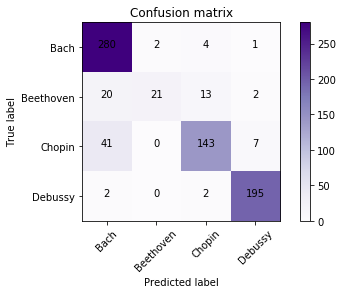

[[268   6  12   1]
 [  8  37  11   0]
 [  8   5 175   3]
 [  3   1   8 187]]


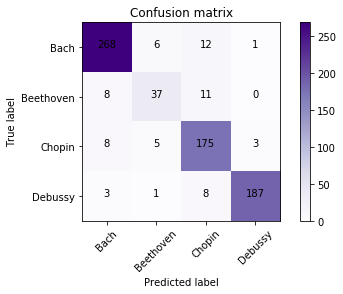

LinearSVC
[[276   2   7   2]
 [ 11  33  11   1]
 [  6   1 182   2]
 [  1   0   2 196]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9373 (0.0384) & 0.9022 (0.0562)
LogisticRegression
[[280   0   5   2]
 [ 46   1   7   2]
 [147   0  44   0]
 [139   0   1  59]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.5237 (0.1017) & 0.342 (0.1238)
KNeighborsClassifier
[[252   3  30   2]
 [ 24  11  21   0]
 [ 34   1 153   3]
 [ 11   1  27 160]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.7859 (0.0444) & 0.6793 (0.0639)
MultinomialNB
[[280   2   4   1]
 [ 20  21  13   2]
 [ 41   0 143   7]
 [  2   0   2 195]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8719 (0.0391) & 0.8189 (0.0598)
MLPClassifier
[[268   6  12   1]
 [  8  37  11   0]
 [  8   5 175   3]
 [  3   1   8 187]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.91 (0.0346) & 0.8774 (0.0405)

-----


['bach_xml0.xml',
 'bach_xml116.xml',
 'bach_xml13.xml',
 'bach_xml130.xml',
 'bach_xml15.xml',
 'bach_xml181.xml',
 'bach_xml187.xml',
 'bach_xml237.xml',
 'bach_xml241.xml',
 'bach_xml251.xml',
 'bach_xml267.xml',
 'bach_xml274.xml',
 'bach_xml46.xml',
 'bach_xml86.xml',
 'beethoven_xml10.xml',
 'beethoven_xml2.xml',
 'beethoven_xml28.xml',
 'beethoven_xml30.xml',
 'beethoven_xml32.xml',
 'beethoven_xml34.xml',
 'beethoven_xml35.xml',
 'beethoven_xml39.xml',
 'beethoven_xml41.xml',
 'beethoven_xml42.xml',
 'beethoven_xml45.xml',
 'beethoven_xml46.xml',
 'beethoven_xml48.xml',
 'beethoven_xml5.xml',
 'beethoven_xml51.xml',
 'beethoven_xml52.xml',
 'beethoven_xml53.xml',
 'beethoven_xml6.xml',
 'beethoven_xml9.xml',
 'chopin_xml112.xml',
 'chopin_xml120.xml',
 'chopin_xml123.xml',
 'chopin_xml150.xml',
 'chopin_xml151.xml',
 'chopin_xml155.xml',
 'chopin_xml171.xml',
 'chopin_xml25.xml',
 'chopin_xml37.xml',
 'chopin_xml57.xml',
 'chopin_xml75.xml',
 'chopin_xml8.xml',
 'chopin_xml97.x

In [21]:
VECTORIZER = CountVectorizer()
benchmark_classifiers(COMPOSERS,NGRAMRANGES,CLASSIFIERS,VECTORIZER)

composer indices [0, 1]


n-gram range (1, 2)
[[287   0]
 [ 11  45]]


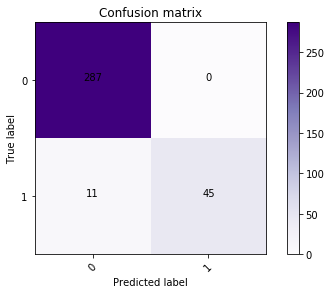

[[278   9]
 [ 17  39]]


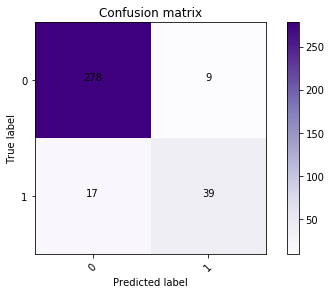

[[287   0]
 [ 25  31]]


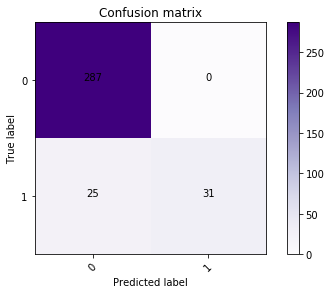

[[281   6]
 [ 21  35]]


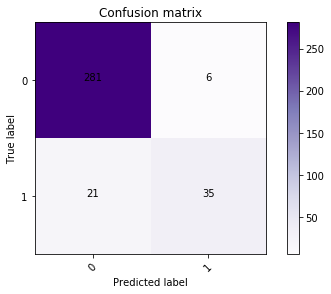

[[283   4]
 [ 21  35]]


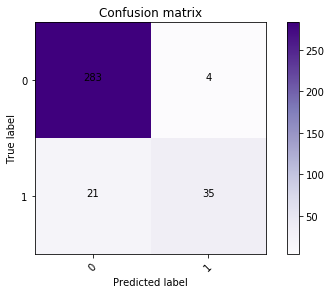

LinearSVC
[[287   0]
 [ 11  45]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9679 (0.0348) & 0.9407 (0.0658)
LogisticRegression
[[278   9]
 [ 17  39]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9242 (0.0415) & 0.8354 (0.0917)
KNeighborsClassifier
[[287   0]
 [ 25  31]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9271 (0.0576) & 0.8546 (0.0936)
MultinomialNB
[[281   6]
 [ 21  35]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.921 (0.0521) & 0.8345 (0.0943)
MLPClassifier
[[283   4]
 [ 21  35]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9269 (0.0692) & 0.8609 (0.1228)

-----
composer indices [0, 2]


n-gram range (1, 2)
[[286   1]
 [  2 189]]


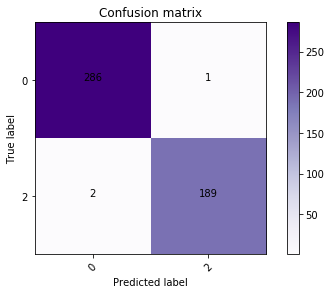

[[277  10]
 [  9 182]]


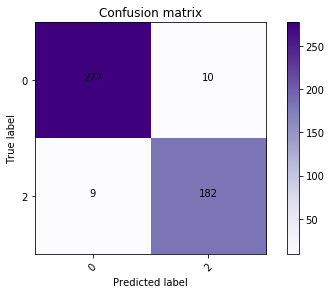

[[287   0]
 [ 56 135]]


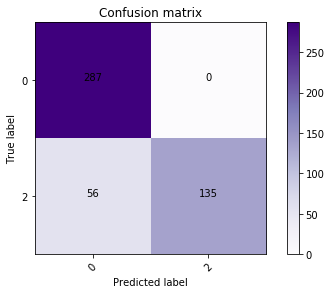

[[283   4]
 [ 27 164]]


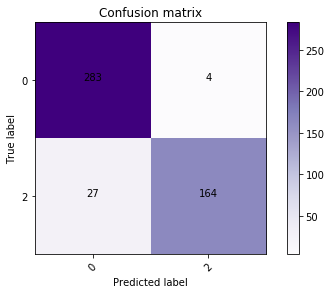

[[282   5]
 [ 10 181]]


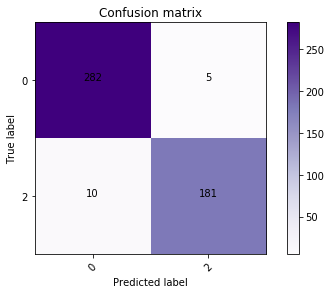

LinearSVC
[[286   1]
 [  2 189]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9938 (0.0101) & 0.9933 (0.0107)
LogisticRegression
[[277  10]
 [  9 182]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9603 (0.0346) & 0.9579 (0.0366)
KNeighborsClassifier
[[287   0]
 [ 56 135]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.883 (0.0449) & 0.8675 (0.0502)
MultinomialNB
[[283   4]
 [ 27 164]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9353 (0.0485) & 0.9307 (0.0506)
MLPClassifier
[[282   5]
 [ 10 181]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9687 (0.0264) & 0.9658 (0.0289)

-----
composer indices [0, 3]


n-gram range (1, 2)
[[287   0]
 [  0 199]]


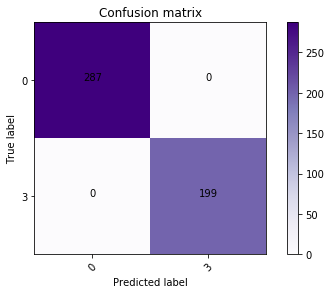

[[285   2]
 [  2 197]]


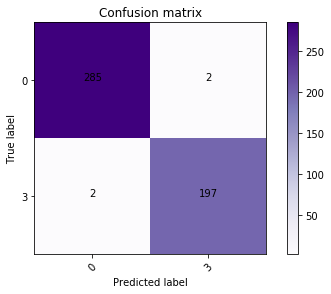

[[287   0]
 [  4 195]]


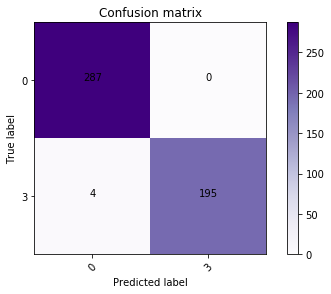

[[281   6]
 [  7 192]]


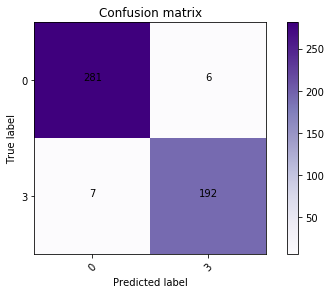

[[285   2]
 [  6 193]]


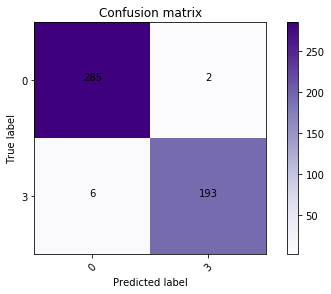

LinearSVC
[[287   0]
 [  0 199]]
micro-averaged f-score (std) & macro-averaged f-score (std)
1.0 (0.0) & 1.0 (0.0)
LogisticRegression
[[285   2]
 [  2 197]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9918 (0.0106) & 0.9914 (0.011)
KNeighborsClassifier
[[287   0]
 [  4 195]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9918 (0.0106) & 0.9914 (0.0112)
MultinomialNB
[[281   6]
 [  7 192]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9733 (0.0196) & 0.972 (0.0203)
MLPClassifier
[[285   2]
 [  6 193]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9835 (0.029) & 0.9827 (0.0303)

-----
composer indices [1, 2]


n-gram range (1, 2)
[[ 43  13]
 [  0 191]]


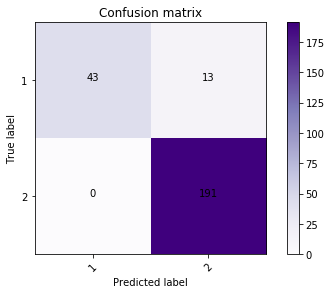

[[ 34  22]
 [  0 191]]


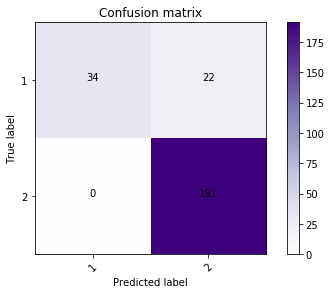

[[ 45  11]
 [  9 182]]


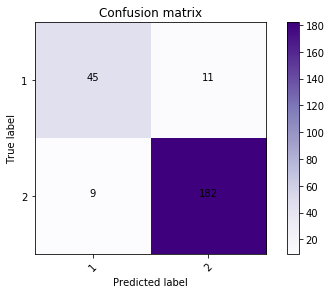

[[ 23  33]
 [  0 191]]


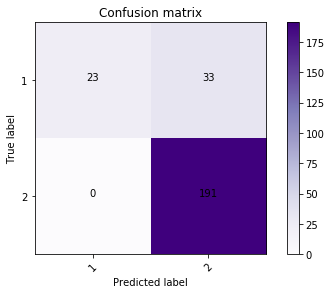

[[ 40  16]
 [  3 188]]


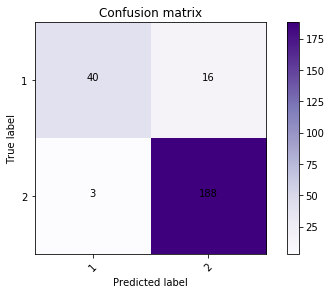

LinearSVC
[[ 43  13]
 [  0 191]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9475 (0.0382) & 0.9179 (0.065)
LogisticRegression
[[ 34  22]
 [  0 191]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9107 (0.0468) & 0.8317 (0.1454)
KNeighborsClassifier
[[ 45  11]
 [  9 182]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9185 (0.0477) & 0.8788 (0.0648)
MultinomialNB
[[ 23  33]
 [  0 191]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.8663 (0.054) & 0.7259 (0.1344)
MLPClassifier
[[ 40  16]
 [  3 188]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9233 (0.0438) & 0.8816 (0.0664)

-----
composer indices [1, 3]


n-gram range (1, 2)
[[ 51   5]
 [  1 198]]


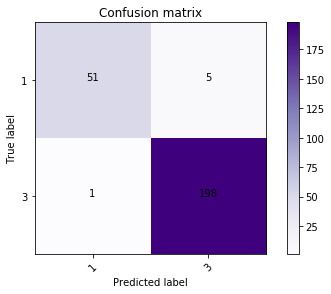

[[ 49   7]
 [  1 198]]


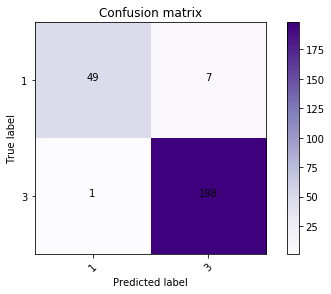

[[ 52   4]
 [  2 197]]


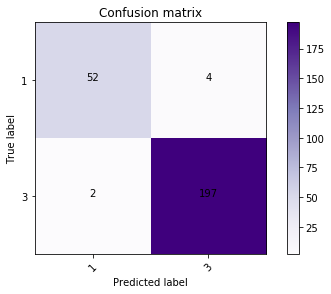

[[ 54   2]
 [  3 196]]


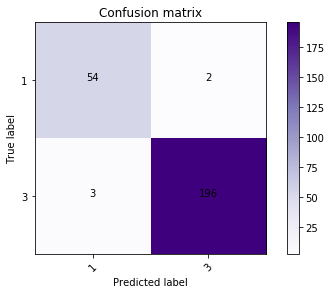

[[ 49   7]
 [  2 197]]


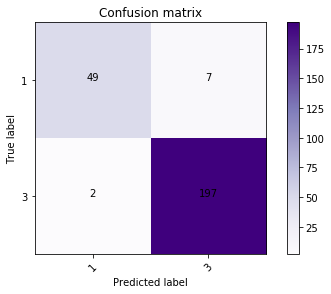

LinearSVC
[[ 51   5]
 [  1 198]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9765 (0.0272) & 0.9643 (0.0472)
LogisticRegression
[[ 49   7]
 [  1 198]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9688 (0.0305) & 0.9541 (0.0491)
KNeighborsClassifier
[[ 52   4]
 [  2 197]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9766 (0.0271) & 0.9624 (0.0482)
MultinomialNB
[[ 54   2]
 [  3 196]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9803 (0.0208) & 0.9728 (0.0292)
MLPClassifier
[[ 49   7]
 [  2 197]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9646 (0.0346) & 0.9461 (0.0547)

-----
composer indices [2, 3]


n-gram range (1, 2)
[[189   2]
 [  3 196]]


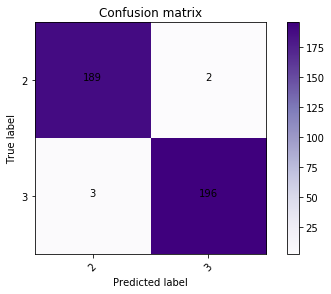

[[180  11]
 [  9 190]]


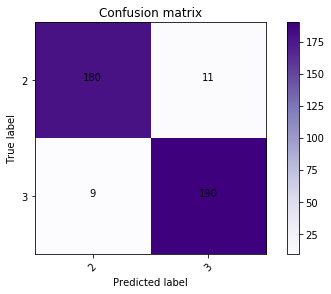

[[181  10]
 [  2 197]]


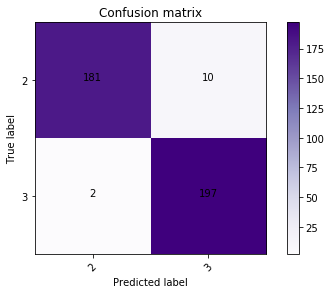

[[186   5]
 [ 10 189]]


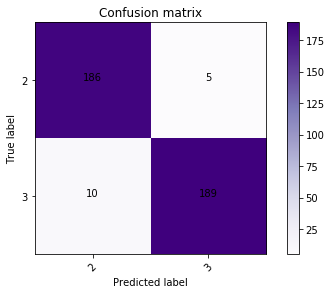

[[184   7]
 [  8 191]]


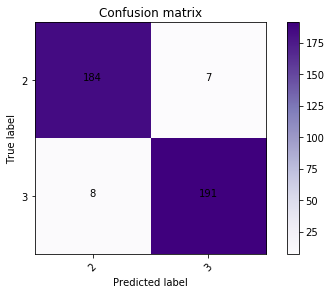

LinearSVC
[[189   2]
 [  3 196]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9872 (0.0181) & 0.9869 (0.0184)
LogisticRegression
[[180  11]
 [  9 190]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9487 (0.0452) & 0.9477 (0.046)
KNeighborsClassifier
[[181  10]
 [  2 197]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9692 (0.0315) & 0.9687 (0.032)
MultinomialNB
[[186   5]
 [ 10 189]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9615 (0.0325) & 0.9609 (0.0331)
MLPClassifier
[[184   7]
 [  8 191]]
micro-averaged f-score (std) & macro-averaged f-score (std)
0.9615 (0.0456) & 0.9611 (0.0459)

-----



In [32]:
NGRAMRANGES = [(1,2)]
VECTORIZER = TfidfVectorizer(sublinear_tf=True)
for indices in tqdm(combinations(range(4),2)):
    print('composer indices',[i for i in indices]) # COMPOSERS = [BACH, BEETHOVEN, CHOPIN, DEBUSSY]
    classes = [i for i in indices]
    benchmark_classifiers([COMPOSERS[i] for i in indices],NGRAMRANGES,CLASSIFIERS,VECTORIZER)

In [15]:
flatten = lambda l: [item for sublist in l for item in sublist]
with open('bach-durations.txt', 'r') as f:
    BA_D = [line.strip() for line in f.readlines()]
with open('beethoven-durations.txt', 'r') as f:
    B_D = [line.strip() for line in f.readlines()]
with open('chopin-durations.txt', 'r') as f:
    CH_D = [line.strip() for line in f.readlines()]
with open('debussy-durations.txt', 'r') as f:
    D_D = [line.strip() for line in f.readlines()]

    
BA_D_TYPELENGTH = [piece.split(';') for piece in BA_D]
B_D_TYPELENGTH = [piece.split(';') for piece in B_D]
CH_D_TYPELENGTH = [piece.split(';') for piece in CH_D]
D_D_TYPELENGTH = [piece.split(';') for piece in D_D]


typelengths = list(set(flatten(BA_D_TYPELENGTH+B_D_TYPELENGTH+CH_D_TYPELENGTH+D_D_TYPELENGTH)))
typelength_dict = {typelengths[i]: str(i+300) for i in range(len(typelengths))}
BA_D_T = [(' '.join([typelength_dict[dur] for dur in piece]),'temp') for piece in BA_D_TYPELENGTH]
B_D_T = [(' '.join([typelength_dict[dur] for dur in piece]),'temp') for piece in B_D_TYPELENGTH]
CH_D_T = [(' '.join([typelength_dict[dur] for dur in piece]),'temp') for piece in CH_D_TYPELENGTH]
D_D_T = [(' '.join([typelength_dict[dur] for dur in piece]),'temp') for piece in D_D_TYPELENGTH]


In [16]:
def crossvalidate_twofeaturesets(X_tuple1, X_tuple2, y, classifiers, vectorizer, range1, range2, K=10):    
    for clf in tqdm(classifiers):
        clf.cm_sum = np.zeros([len(set(y)),len(set(y))], dtype='int16')
        clf.accuracies, clf.fones, clf.misclassified, clf.runningtime = [], [], [], []
        clf.fones_micro, clf.fones_macro = [], []
        clf.name = str(clf).split('(')[0]

    X1 = np.array([piece[0] for piece in X_tuple1])
    X2 = np.array([piece[0] for piece in X_tuple2])
    filenames = np.array([piece[1] for piece in X_tuple2])
    kf = KFold(n_splits=K, shuffle=True)
    for train_index, test_index in kf.split(y):
        y_train, y_test = y[train_index], y[test_index]
        X_train_new, X_test_new = X1[train_index], X1[test_index]
        vct1 = vectorizer.set_params(ngram_range=range1)
        X_train, X_test = X2[train_index], X2[test_index] 
        vct2 = vectorizer.set_params(ngram_range=range2)
   
        X_train_new_tfidf = vct1.fit_transform(X_train_new) # use two separate vectorizers for each feature set
        X_test_new_tfidf = sp.vstack([vct1.transform(np.array([piece])) for piece in X_test_new])
        X_train_tfidf = vct2.fit_transform(X_train)
        X_test_tfidf = sp.vstack([vct2.transform(np.array([piece])) for piece in X_test])
        
        X_train_tfidf = sp.hstack((X_train_tfidf, X_train_new_tfidf)) # Merge the two feature sets
        X_test_tfidf = sp.hstack((X_test_tfidf, X_test_new_tfidf))
        
        for clf in classifiers:
            t = datetime.now()
            clf.fit(X_train_tfidf, y_train)
            y_pred = clf.predict(X_test_tfidf)
            clf.runningtime.append((datetime.now()-t).total_seconds())
            clf.cm_sum += confusion_matrix(y_test, y_pred)
            clf.misclassified.append(test_index[np.where(y_test != y_pred)]) # http://stackoverflow.com/a/25570632
            clf.accuracies.append(accuracy_score(y_test, y_pred))
            clf.fones.append(f1_score(y_test, y_pred, average='weighted'))
            clf.fones_micro.append(f1_score(y_test, y_pred, average='micro'))
            clf.fones_macro.append(f1_score(y_test, y_pred, average='macro'))

    result = dict()
    for clf in tqdm(classifiers):
        clf.misclassified = np.sort(np.hstack(clf.misclassified))
        result[clf.name] = [clf.cm_sum, clf.accuracies, clf.fones, 
                            clf.misclassified, filenames[clf.misclassified], 
                            clf.runningtime, clf.fones_micro, clf.fones_macro]
      
        # Plot non-normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(clf.cm_sum, classes=classes,
                              title='Confusion matrix',
                              normalize = True)


        plt.show()
    return result

In [17]:
def benchmark_classifiers_twofeaturesets(composers1, composers2, range1, range2, classifiers, vectorizer, n=1, retrieve_title=True):
    misclassified_list = []
    print('duration n-gram range:', range1, 'chord n-gram range:', range2)
    X1, y = build_Xy(composers1, size=n)
    X2, y = build_Xy(composers2, size=n)
    cv_result = crossvalidate_twofeaturesets(X1, X2, y, classifiers, vectorizer, range1, range2)
    for clf, results in cv_result.items():
        print(clf)
        cm = results[0]
        print(cm)
        acc = results[1]
        fones = results[2]
        misclassified = results[3]
        misclassified_filenames = results[4]
        misclassified_list += list(misclassified_filenames)
        print('misclassified',[(misclassified[i], misclassified_filenames[i]) for i in range(len(misclassified))])
        runningtime = results[5]
        print('running time', np.sum(runningtime))
        fones_micro = results[6]
        fones_macro = results[7]
        print('F-measures')
        print(round(np.mean(fones_micro),4), '({})'.format(round(np.std(fones_micro, ddof=1),4)), '&', round(np.mean(fones_macro),4), '({})'.format(round(np.std(fones_macro, ddof=1),4)))
    print('-----')
    return misclassified_list

In [20]:
classes = ['Bach', 'Beethoven', 'Chopin', 'Debussy']
CLASSIFIERS = [svm.LinearSVC(penalty='l2', C=5, loss='hinge'),
               linear_model.LogisticRegression(penalty='l2', C=100, tol=1, multi_class='multinomial', solver='sag'),
               neighbors.KNeighborsClassifier(weights='distance'),
               naive_bayes.MultinomialNB(alpha=0.00001, fit_prior=False),
               neural_network.MLPClassifier(solver='lbfgs',hidden_layer_sizes=(10,))]
VECTORIZER = TfidfVectorizer(sublinear_tf=True, lowercase=False, token_pattern=u"(?u)\\b\\w+\\b")

COMPOSERS1 = [BA_D_T,B_D_T,CH_D_T,D_D_T]
COMPOSERS2 = [BACH, BEETHOVEN, CHOPIN, DEBUSSY]

duration n-gram range: (1, 1) chord n-gram range: (1, 2)


[[283   1   3   0]
 [  0  54   2   0]
 [  2   1 187   1]
 [  0   0   0 199]]


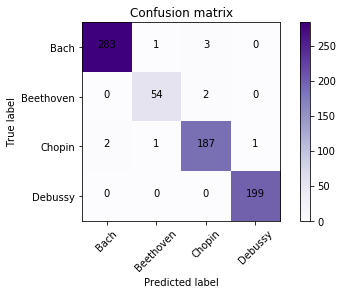

[[270   2  14   1]
 [  0  34  22   0]
 [ 10   8 172   1]
 [  1   1   0 197]]


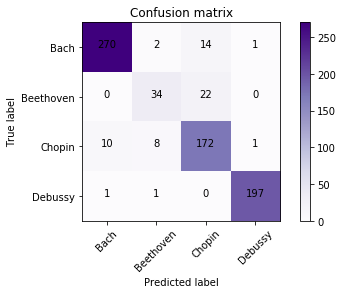

[[282   1   4   0]
 [  1  48   7   0]
 [ 27  19 144   1]
 [  0   0   0 199]]


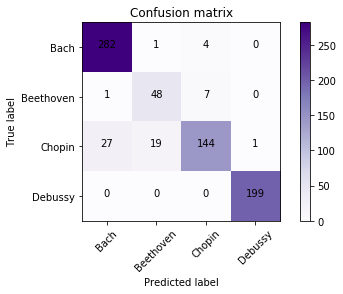

[[283   0   4   0]
 [  9  31  16   0]
 [ 19   0 171   1]
 [  0   0   0 199]]


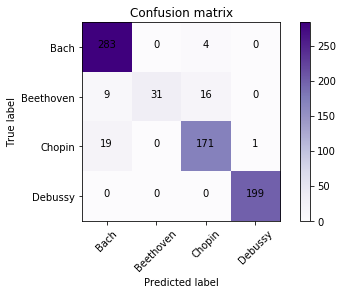

[[281   2   4   0]
 [  1  45  10   0]
 [  7   7 176   1]
 [  0   1   0 198]]


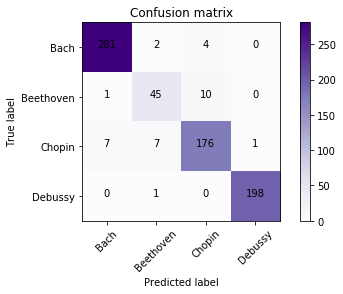


LinearSVC
[[283   1   3   0]
 [  0  54   2   0]
 [  2   1 187   1]
 [  0   0   0 199]]
misclassified [(36, 'bach_xml130.xml'), (150, 'bach_xml233.xml'), (160, 'bach_xml242.xml'), (265, 'bach_xml8.xml'), (317, 'beethoven_xml36.xml'), (324, 'beethoven_xml42.xml'), (359, 'chopin_xml112.xml'), (473, 'chopin_xml44.xml'), (475, 'chopin_xml46.xml'), (514, 'chopin_xml81.xml')]
running time 3.4126320000000003
F-measures
0.9863 (0.0129) & 0.9815 (0.0199)
LogisticRegression
[[270   2  14   1]
 [  0  34  22   0]
 [ 10   8 172   1]
 [  1   1   0 197]]
misclassified [(25, 'bach_xml120.xml'), (26, 'bach_xml121.xml'), (35, 'bach_xml13.xml'), (36, 'bach_xml130.xml'), (41, 'bach_xml135.xml'), (45, 'bach_xml139.xml'), (56, 'bach_xml149.xml'), (69, 'bach_xml160.xml'), (150, 'bach_xml233.xml'), (152, 'bach_xml235.xml'), (153, 'bach_xml236.xml'), (160, 'bach_xml242.xml'), (161, 'bach_xml243.xml'), (207, 'bach_xml285.xml'), (221, 'bach_xml4.xml'), (243, 'bach_xml6.xml'), (265, 'bach_xml8.xml'), (289, 'beeth

['bach_xml130.xml',
 'bach_xml233.xml',
 'bach_xml242.xml',
 'bach_xml8.xml',
 'beethoven_xml36.xml',
 'beethoven_xml42.xml',
 'chopin_xml112.xml',
 'chopin_xml44.xml',
 'chopin_xml46.xml',
 'chopin_xml81.xml',
 'bach_xml120.xml',
 'bach_xml121.xml',
 'bach_xml13.xml',
 'bach_xml130.xml',
 'bach_xml135.xml',
 'bach_xml139.xml',
 'bach_xml149.xml',
 'bach_xml160.xml',
 'bach_xml233.xml',
 'bach_xml235.xml',
 'bach_xml236.xml',
 'bach_xml242.xml',
 'bach_xml243.xml',
 'bach_xml285.xml',
 'bach_xml4.xml',
 'bach_xml6.xml',
 'bach_xml8.xml',
 'beethoven_xml10.xml',
 'beethoven_xml11.xml',
 'beethoven_xml12.xml',
 'beethoven_xml16.xml',
 'beethoven_xml17.xml',
 'beethoven_xml23.xml',
 'beethoven_xml29.xml',
 'beethoven_xml3.xml',
 'beethoven_xml30.xml',
 'beethoven_xml38.xml',
 'beethoven_xml39.xml',
 'beethoven_xml42.xml',
 'beethoven_xml43.xml',
 'beethoven_xml46.xml',
 'beethoven_xml47.xml',
 'beethoven_xml50.xml',
 'beethoven_xml51.xml',
 'beethoven_xml52.xml',
 'beethoven_xml6.xml',
 '

In [39]:
benchmark_classifiers_twofeaturesets(COMPOSERS1, COMPOSERS2, (1,1), (1,2), CLASSIFIERS, VECTORIZER)

In [18]:
import pickle

In [29]:
filename = 'Multi_Classifier_Ba_Be_CH_D.sav'
VECTORIZER = TfidfVectorizer(sublinear_tf=True)

model = svm.LinearSVC(penalty='l2', C=5, loss='hinge')

In [30]:
pickle.dump(model, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model
print(result)

LinearSVC(C=5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)


duration n-gram range: (1, 1) chord n-gram range: (1, 2)


[[285   1   1   0]
 [  0  54   2   0]
 [  0   2 188   1]
 [  0   0   0 199]]


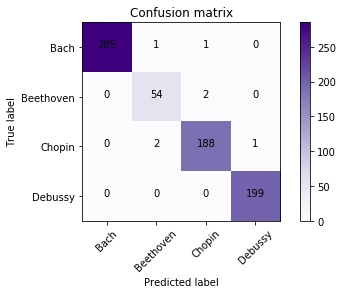


LinearSVC
[[285   1   1   0]
 [  0  54   2   0]
 [  0   2 188   1]
 [  0   0   0 199]]
misclassified [(150, 'bach_xml233.xml'), (160, 'bach_xml242.xml'), (299, 'beethoven_xml2.xml'), (310, 'beethoven_xml3.xml'), (473, 'chopin_xml44.xml'), (475, 'chopin_xml46.xml'), (502, 'chopin_xml70.xml')]
running time 2.2103569999999997
F-measures
0.9904 (0.013) & 0.9846 (0.0221)
-----


['bach_xml233.xml',
 'bach_xml242.xml',
 'beethoven_xml2.xml',
 'beethoven_xml3.xml',
 'chopin_xml44.xml',
 'chopin_xml46.xml',
 'chopin_xml70.xml']

In [22]:
filename = 'Multi_Classifier_Ba_Be_CH_D.sav'
VECTORIZER = TfidfVectorizer(sublinear_tf=True)
loaded_model = pickle.load(open(filename, 'rb'))
classifier = [loaded_model]

benchmark_classifiers_twofeaturesets(COMPOSERS1, COMPOSERS2, (1,1), (1,2), classifier, VECTORIZER)